# Heart Disease Prediction (Cardiopatía)

> Añadidos blockquote


**Curso:** Gestion de Análisis de Datos

---

## OBJETIVOS

### Objetivo General:

Construir un modelo predictivo que identifique pacientes con alta probabilidad de desarrollar enfermedad cardíaca basándose en:

- **Variables clínicas:** presión arterial, colesterol, glucosa,
electrocardiograma

- **Características demográficas:** edad, sexo

- **Factores de estilo de vida:** tabaquismo, actividad física, tipo de dolor torácico

- **Variable objetivo:** Presencia de enfermedad cardíaca (Binaria: 0=No, 1=Sí)

- **Modelo a trabajar:** Regresión Logística Binaria

  - **Justificación:** Permite estimar probabilidades de riesgo cardiovascular e identificar factores de riesgo mediante odds ratios interpretables por médicos.

## FECHA DE ENTREGA

**Fecha límite:** 6 de diciembre

**Modalidad:** Archivo PDF + Enlace de Google Colab  

**Plataforma:** Aula Virtual TECSUP

---
**Dataset:** https://archive.ics.uci.edu/dataset/45/heart+disease

**Link Colab:** https://colab.research.google.com/drive/15yXsy5no5a8-h0Tv-Mf0xucmPKbwRb1m?usp=sharing

**Elaborado por:**

- Arteaga Guerra, Pedro Sebastian Alfieri
- Espinoiza Tuesta, Renzo
- Furushio Casanave, Piero Hideki
- Salazar Chávez, Renzo Sebastian
- Villasante López, Bryan Jean Pierre

**Última actualización:** 06/12/25

In [ ]:
# ========================
#  Configuración inicial
# ========================

# (1) Instalacion de Librerías Adicionales
!pip install ucimlrepo
!pip install boruta
!pip install kneed

# (2) Imports principales
import numpy as np # Cálculo numérico
import pandas as pd # DataFrames
import matplotlib.pyplot as plt # Visualización base
import seaborn as sns # Visualización avanzada

from ucimlrepo import fetch_ucirepo # Datasets UCI via sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, learning_curve # Mejor selección de parámetros
from sklearn.preprocessing import StandardScaler # Escalado
from sklearn.linear_model import LogisticRegression # Regresión logística
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay,
                           classification_report, log_loss, make_scorer) # Métricas

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF
from statsmodels.tools.tools import add_constant # Necesario para evitar errores internos al aplicar el VIF

from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import shap

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

from typing import Tuple, List, Dict, Any

import warnings; warnings.filterwarnings('ignore') # Salida limpia

# (3) Semilla para reproducibilidad
np.random.seed(42)

# (4) Configuracion de stilos
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")
sns.set_palette("husl")

## Muestreo (Sample)

### Definir el universo de datos

#### Adquirir los datos del repositorio UCI

In [ ]:
# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# Unir X e y para procesamiento
Cardiopatia_df = pd.concat([X, y], axis=1)

# Renombrar variables para mejor entendimiento
Cardiopatia_df = Cardiopatia_df.rename(columns={
    'age': 'edad',
    'sex': 'sexo',
    'cp': 'tipo_dolor_pecho',
    'trestbps': 'presion_arterial_reposo',
    'chol': 'colesterol',
    'fbs': 'azucar_ayunas',
    'restecg': 'electrocardiograma_reposo',
    'thalach': 'frecuencia_cardiaca_max',
    'exang': 'angina_ejercicio',
    'oldpeak': 'depresion_ST',
    'slope': 'pendiente_ST',
    'ca': 'vasos_coloreados',
    'thal': 'talasemia',
    'num': 'enfermedad_cardiaca'
})

# Mostrar primeros 4 registros
print("Datos originales:")
print(Cardiopatia_df.head(4))

Datos originales:
   edad  sexo  tipo_dolor_pecho  presion_arterial_reposo  colesterol  \
0    63     1                 1                      145         233   
1    67     1                 4                      160         286   
2    67     1                 4                      120         229   
3    37     1                 3                      130         250   

   azucar_ayunas  electrocardiograma_reposo  frecuencia_cardiaca_max  \
0              1                          2                      150   
1              0                          2                      108   
2              0                          2                      129   
3              0                          0                      187   

   angina_ejercicio  depresion_ST  pendiente_ST  vasos_coloreados  talasemia  \
0                 0           2.3             3               0.0        6.0   
1                 1           1.5             2               3.0        3.0   
2                 1 

#### Describir el dataset

In [ ]:
print("\n📋 INFORMACIÓN BÁSICA DEL DATASET:")
print(f"• Observaciones: {Cardiopatia_df.shape[0]}")
print(f"• Variables predictoras: {Cardiopatia_df.shape[1]-1}")
print(f"• Forma del dataset: {Cardiopatia_df.shape}")


📋 INFORMACIÓN BÁSICA DEL DATASET:
• Observaciones: 303
• Variables predictoras: 13
• Forma del dataset: (303, 14)


In [ ]:
Cardiopatia_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   edad                       303 non-null    int64  
 1   sexo                       303 non-null    int64  
 2   tipo_dolor_pecho           303 non-null    int64  
 3   presion_arterial_reposo    303 non-null    int64  
 4   colesterol                 303 non-null    int64  
 5   azucar_ayunas              303 non-null    int64  
 6   electrocardiograma_reposo  303 non-null    int64  
 7   frecuencia_cardiaca_max    303 non-null    int64  
 8   angina_ejercicio           303 non-null    int64  
 9   depresion_ST               303 non-null    float64
 10  pendiente_ST               303 non-null    int64  
 11  vasos_coloreados           299 non-null    float64
 12  talasemia                  301 non-null    float64
 13  enfermedad_cardiaca        303 non-null    int64  

      Hay un total de 303 datos, con 14 columnas (3 discretas, 11 continuas)

### Dividir en subconjuntos

Devido a sus dimenciones, escojemos usar una validacion crusada.

In [ ]:
# Calcular mediana
mediana_edad = Cardiopatia_df["edad"].median()

# Crear grupo binario: 0 = <= mediana, 1 = > mediana
Cardiopatia_df["grupo_edad"] = (Cardiopatia_df["edad"] > mediana_edad).astype(int)

# Crear variable combinada para estratificación
Cardiopatia_df["estrato"] = (
    Cardiopatia_df["enfermedad_cardiaca"].astype(str) + "_" +
    Cardiopatia_df["grupo_edad"].astype(str) )

# Separar X e y
X = Cardiopatia_df.drop(["enfermedad_cardiaca", "estrato"], axis=1)
y = Cardiopatia_df["enfermedad_cardiaca"]
estratos = Cardiopatia_df["estrato"]

# Estratificación por enfermedad y grupo de edad
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=estratos, random_state=42 )

print("Entrenamiento:", X_train.shape)
print("Prueba:", X_test.shape)

Entrenamiento: (212, 14)
Prueba: (91, 14)


Se utilizó una división 70-30 para garantizar una evaluación robusta del modelo, preservando suficiente información para el entrenamiento sin comprometer la capacidad de validación. Esta proporción permite detectar sobreajuste y comparar el rendimiento entre modelos de forma confiable

### Verificar representatividad

#### Comparar proporciones de la variable objetivo

In [ ]:
print("Dataset completo:", y.value_counts(normalize=True))
print("\nTrain:", y_train.value_counts(normalize=True))
print("\nPrueba:", y_test.value_counts(normalize=True))

Dataset completo: enfermedad_cardiaca
0    0.541254
1    0.181518
2    0.118812
3    0.115512
4    0.042904
Name: proportion, dtype: float64

Train: enfermedad_cardiaca
0    0.542453
1    0.179245
2    0.117925
3    0.117925
4    0.042453
Name: proportion, dtype: float64

Prueba: enfermedad_cardiaca
0    0.538462
1    0.186813
2    0.120879
3    0.109890
4    0.043956
Name: proportion, dtype: float64


#### Comparar estadísticas descriptivas de variables predictoras

In [ ]:
print("Media edad - completo:", Cardiopatia_df["edad"].mean())
print("Media edad - train:", X_train["edad"].mean())
print("Media edad - test:", X_test["edad"].mean())

Media edad - completo: 54.43894389438944
Media edad - train: 54.43867924528302
Media edad - test: 54.43956043956044


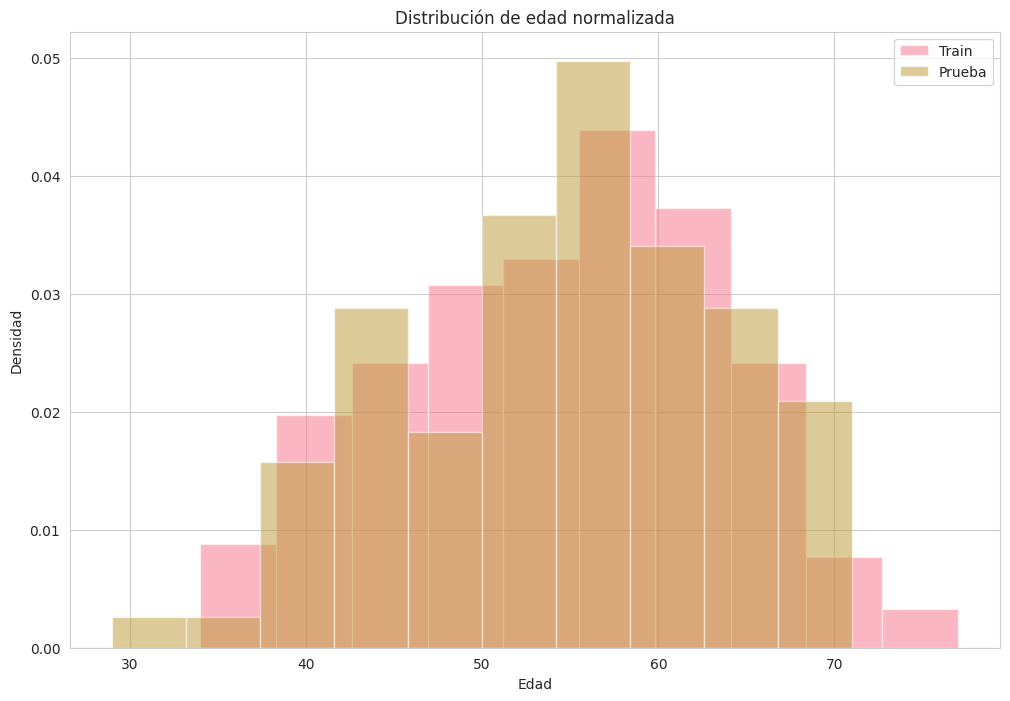

In [ ]:
plt.hist(X_train["edad"], bins=10, alpha=0.5, label="Train", density=True)
plt.hist(X_test["edad"], bins=10, alpha=0.5, label="Prueba", density=True)
plt.legend()
plt.title("Distribución de edad normalizada")
plt.xlabel("Edad")
plt.ylabel("Densidad")
plt.show()

## Exploración (Explore)

A pesar de que hemos estratificado y que en la metodologia SEMMA, en esta fase, se suele usar la parte de entrenamiento (train).
Ya que la base de datos es relativamente pequeña, se recomienda evaluar las exploraciones con la base de datos sin estratificar.

#### Importancia medica de cada variable:
- **edad:** Edad del paciente.
- **sexo:** 1 = hombre, 0 = mujer
- **tipo_dolor_pecho:** El tipo de dolor puede indicar gravedad o presencia de enfermedad
- **presion_arterial_reposo:** Puede detectar Hipertensión
- **colesterol:** Colesterol alto, riesgo de arteriosclerosis
- **azucar_ayunas:** Puede detectar Diabetes
- **electrocardiograma_reposo:** Puede mostrar signos de hipertrofia o arritmia
- **frecuencia_cardiaca_max:** Baja respuesta puede indicar disfunción cardíaca
- **angina_ejercicio:** Dolor durante el ejercicio indica posible obstrucción coronaria
- **depresion_ST:** Indica isquemia miocárdica
- **pendiente_ST:** Cambios en ST reflejan respuesta cardíaca al esfuerzo
- **vasos_coloreados:** Número de vasos principales coloreados por fluoroscopía
- **talasemia:** Tipo de anomalía en prueba de talio
- **enfermedad_cardiaca:** Diagnóstico final

### Realizar Análisis Exploratorio de Datos (EDA)

#### Estadísticas descriptivas univariadas

In [ ]:
print(Cardiopatia_df.describe().round(3)[1:].T)

                              mean     std    min    25%    50%    75%    max
edad                        54.439   9.039   29.0   48.0   56.0   61.0   77.0
sexo                         0.680   0.467    0.0    0.0    1.0    1.0    1.0
tipo_dolor_pecho             3.158   0.960    1.0    3.0    3.0    4.0    4.0
presion_arterial_reposo    131.690  17.600   94.0  120.0  130.0  140.0  200.0
colesterol                 246.693  51.777  126.0  211.0  241.0  275.0  564.0
azucar_ayunas                0.149   0.356    0.0    0.0    0.0    0.0    1.0
electrocardiograma_reposo    0.990   0.995    0.0    0.0    1.0    2.0    2.0
frecuencia_cardiaca_max    149.607  22.875   71.0  133.5  153.0  166.0  202.0
angina_ejercicio             0.327   0.470    0.0    0.0    0.0    1.0    1.0
depresion_ST                 1.040   1.161    0.0    0.0    0.8    1.6    6.2
pendiente_ST                 1.601   0.616    1.0    1.0    2.0    2.0    3.0
vasos_coloreados             0.672   0.937    0.0    0.0    0.0 

      Análisis exploratorio de variables clínicas

      - edad: La media es de 54 años, con un rango entre 29 y 77.

      - sexo: Codificación binaria (0 = mujer, 1 = hombre). La media de ~0.68 sugiere una mayor proporción de hombres en la muestra.

      - tipo_dolor_pecho: Variable categórica con valores entre 0 y 3. Representa distintos tipos de dolor torácico. La distribución puede aportar información sobre la presentación clínica, pero requiere análisis cruzado con otras variables.

      - presion_arterial_reposo: Media de 131 mmHg, con valores entre 94 y 200. Se detecta que es exesivamente elevado. Pues, supera el rango aceptable de 140. Se marca como inconsistencia.
        - http://www.guiadeenfermeria.org/2020/01/tablas-de-signos-vitales-por-edades.html

      - colesterol: Media de 246 mg/dL, con un máximo de 564. Este valor exede el rango a considerar valido de 300. Se marca como inconsistente.
        - https://www.mayoclinic.org/es/diseases-conditions/heart-disease/in-depth/heart-disease/art-20049357

      - azucar_ayunas: Codificación binaria (0 = normal, 1 = >120 mg/dL). La media de ~0.15 indica que la mayoría de pacientes no presentan hiperglucemia en ayunas.

      - electrocardiograma_reposo: Valores entre 0 y 2. Representa distintos hallazgos en el ECG en reposo. No se observan valores fuera del rango esperado.

      - frecuencia_cardiaca_max: Media de 149 bpm, con un máximo de 202. Aunque 202 bpm es elevado, puede alcanzarse en pruebas de esfuerzo en pacientes jóvenes. No se considera inconsistente.
        - https://www.tuasaude.com/es/frecuencia-cardiaca/

      - angina_ejercicio: Codificación binaria. La media de ~0.33 sugiere que un tercio de los pacientes presenta dolor durante el ejercicio.

      - depression_ST: Media de ~1.04, con un máximo de 6.2. Valores superiores a 4 suelen indicar isquemia significativa. Aunque 6.2 es alto, sigue siendo clínicamente posible en casos graves. No se descarta, pero se recomienda precaución.
        - https://www.udocz.com/apuntes/396935/ecg-pdf-1

      - pendiente_ST: Variable categórica (0 a 2). Representa la forma del segmento ST durante el esfuerzo. No se observan valores fuera del rango esperado.

      - vasos_coloreados: Número de vasos principales afectados (0 a 3). La media de ~0.67 sugiere que la mayoría tiene pocos vasos comprometidos.

      - talasemia: Variable categórica (1 a 3). Representa resultados de la prueba de talio. No se observan valores fuera del rango esperado.

      - enfermedad_cardiaca: Variable objetivo con valores entre 0 y 2. Se interpreta como una clasificación multicategoría de la condición cardíaca.

      No se asume ninguna predicción en esta etapa. Se requiere modelado posterior para evaluar su relación con las variables anteriores.

#### Análisis de distribuciones

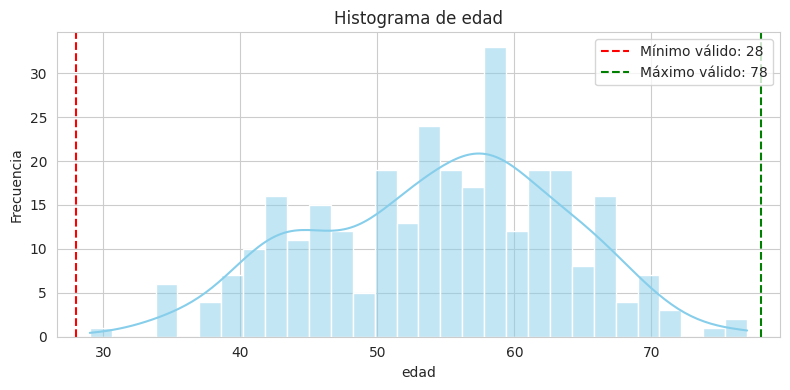

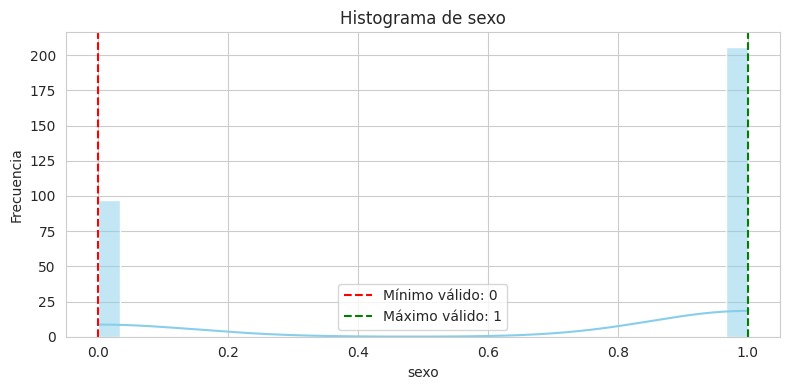

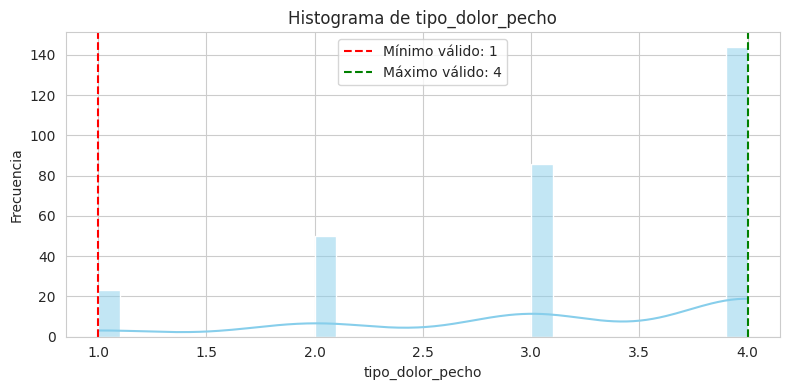

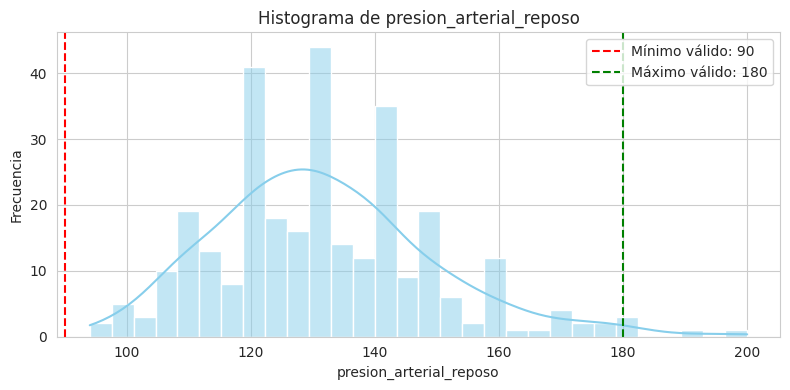

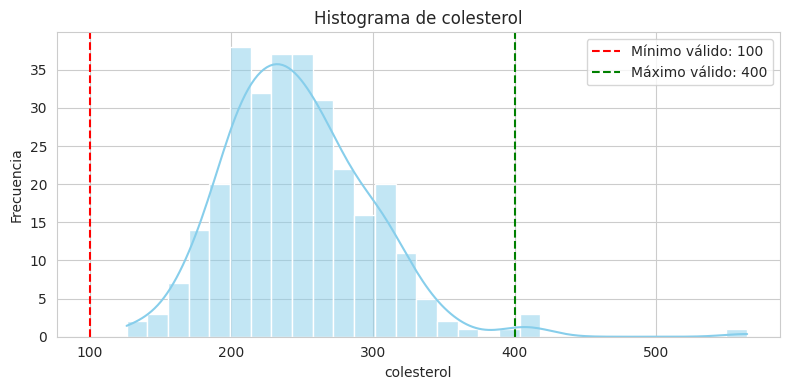

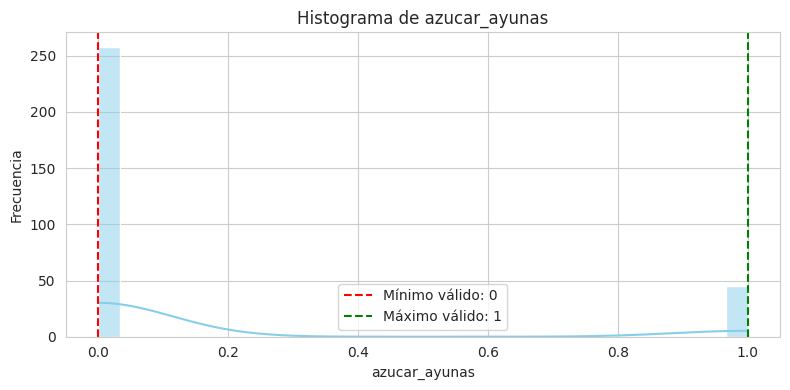

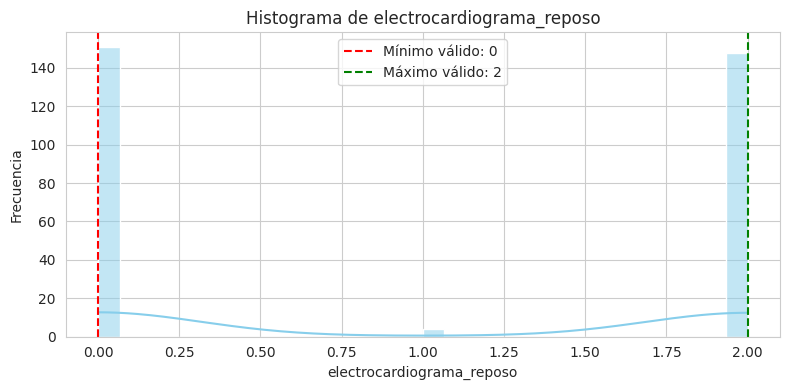

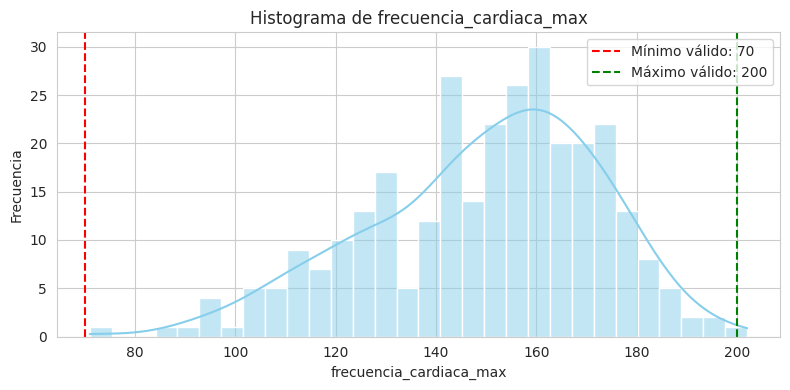

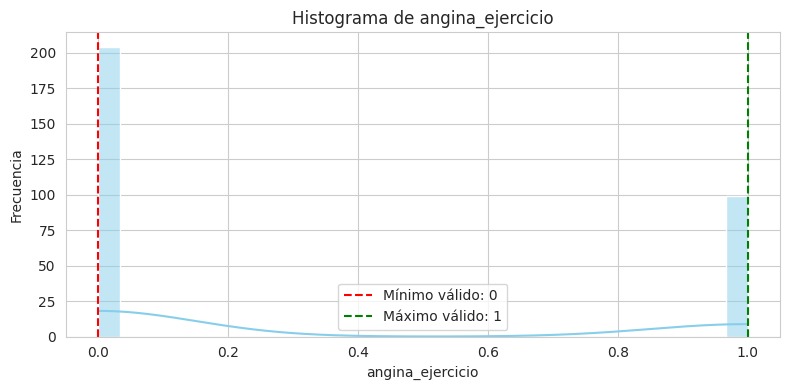

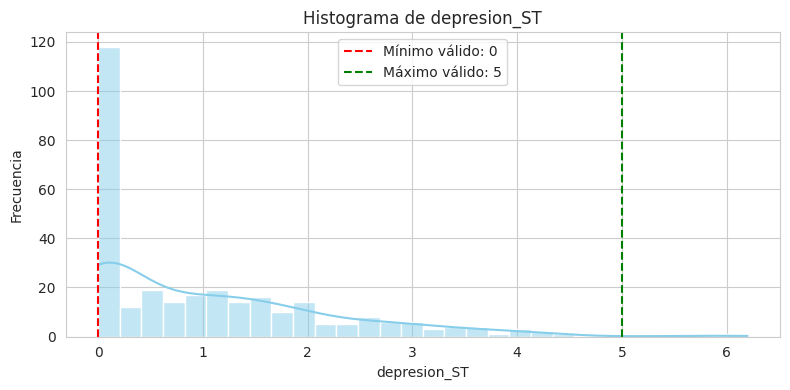

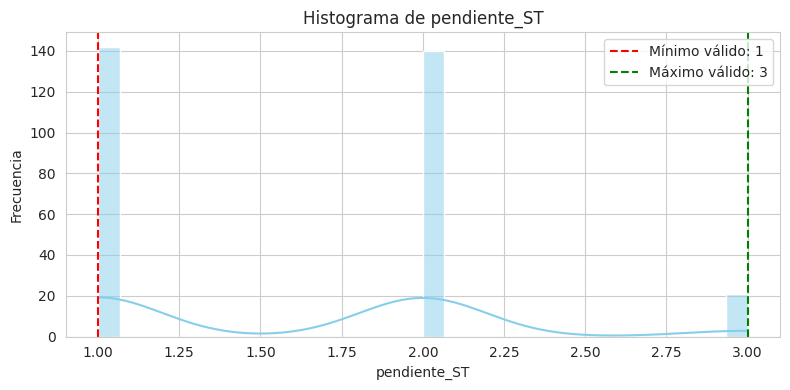

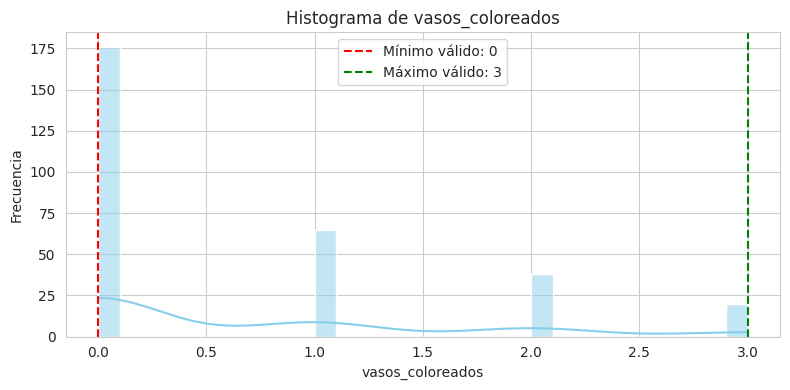

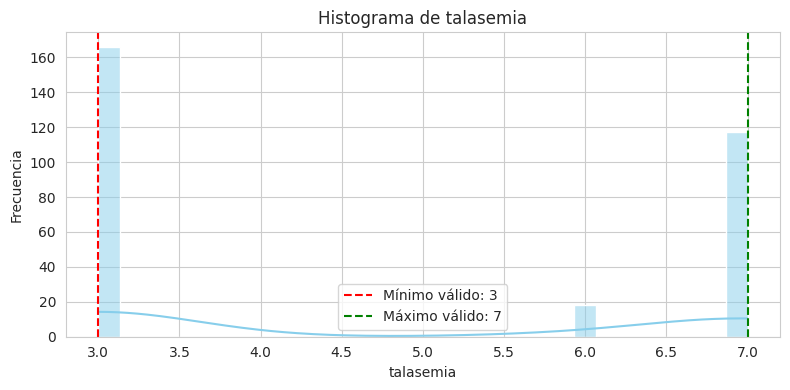

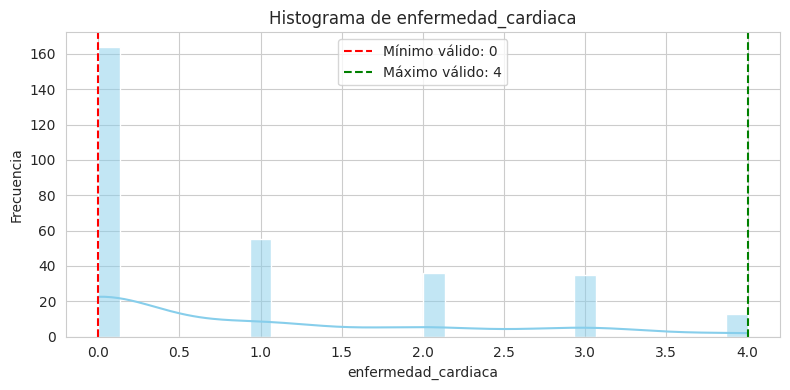

In [ ]:
# ========================
# Datos inconsistentes
# ========================

rangos_validos = {
    'edad': (28, 78),
    'sexo': (0, 1),
    'tipo_dolor_pecho': (1, 4),
    'presion_arterial_reposo': (90, 180),
    'colesterol': (100, 400),
    'azucar_ayunas': (0, 1),
    'electrocardiograma_reposo': (0, 2),
    'frecuencia_cardiaca_max': (70, 200),
    'angina_ejercicio': (0, 1),
    'depresion_ST': (0, 5),
    'pendiente_ST': (1, 3),
    'vasos_coloreados': (0, 3),
    'talasemia': (3, 7),
    'enfermedad_cardiaca': (0, 4)
}

# Graficar cada variable
for col, (min_val, max_val) in rangos_validos.items():
    plt.figure(figsize=(8, 4))
    sns.histplot(Cardiopatia_df[col], bins=30, kde=True, color='skyblue')
    plt.axvline(min_val, color='red', linestyle='--', label=f'Mínimo válido: {min_val}')
    plt.axvline(max_val, color='green', linestyle='--', label=f'Máximo válido: {max_val}')
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.tight_layout()
    plt.show()

Aunque se ha realisado un histograma a cada variable indiscriminadamente, hay que remarcar la existencia de 8 categoricos que han sido mostrados. Los cuales se aprecian por no tener datos continuos y por ende no dibujar la campana de GAUS.

      A continuación se describen los hallazgos observados en los histogramas de cada variable:

      - edad:
        - La variable edad presenta una distribución bimodal centrada, además de alta dispersión, concentrando los valores aproximadamente de 40 a 50 y 50 a 60. Permitiendo así, una posible segmentación.
      - sexo:
        - Variable categórica binaria con el doble de registros en el valor 0 respecto al valor 1.
      - tipo_dolor_pecho:
        - Variable categórica distribuida de forma descendente en frecuencia, desde el tipo 4 hasta el tipo 1.
      - presion_arterial_reposo:
        - Muestra una distribución sesgada positivamente, con una curva baja y ancha que indica alta dispersión. Los valores se concentran entre 120 y 140 mmHg.
      - colesterol:
        - Se observa una distribución centrada con curva alta y estrecha, lo que refleja baja dispersión y alta concentración de valores entre 200 y 250 mg/dL.
      - azucar_ayunas:
        - Variable categórica binaria con predominancia del valor 0; el valor 1 representa aproximadamente una quinta parte de los registros.
      - electrocardiograma_reposo:
        - Variable categórica con tres niveles. Los valores 0 y 2 presentan frecuencias similares, mientras que el valor 1 es poco frecuente.
      - frecuencia_cardiaca_max:
        - Presenta una distribución sesgada negativamente, con alta dispersión. La mayoría de los valores se agrupan alrededor de los 160 bpm.
      - angina_ejercicio:
        - Variable categórica binaria con mayor presencia del valor 0; el valor 1 aparece en aproximadamente la mitad de los casos.
      - depression_ST:
        - Muestra una distribución sesgada positivamente, con alta dispersión y una concentración marcada en el valor 0.
      - pendiente_ST:
        - Variable categórica con frecuencias similares en los valores 1 y 2, mientras que el valor 3 es poco frecuente.
      - vasos_coloreados:
        - Variable categórica con predominancia del valor 0, seguida por una distribución decreciente en los valores 1, 2 y 3.
      - talasemia:
        - Variable categórica con ausencia de registros en el valor 4, muy pocos en 5 y 6, y alta concentración en el valor 3, seguido del 7.
      - enfermedad_cardiaca:
        - Variable categórica con mayor presencia del valor 0. Los valores del 1 al 4 se distribuyen en orden descendente de frecuencia.


##### filtro_rangos

In [ ]:
def aplicar_filtro_rangos(df, rangos_validos, verbose = False):
    """
    Aplica un filtro de rangos válidos a las columnas de un DataFrame.

    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame sobre el que se aplicará el filtro.
    rangos_validos : dict
        Diccionario con el formato {"columna": (min_val, max_val)}.
    verbose : bool, opcional (default=False)
        Si es True, la función imprime mensajes y muestra detalles
        adicionales del proceso. Si es False, trabaja en silencio.

    Retorna:
    --------
    df_filtrado : pandas.DataFrame
        DataFrame con valores fuera de rango reemplazados por NaN.
    resumen_na : pandas.Series
        Conteo de valores NaN por columna.
    """
    df_filtrado = df.copy()
    for col, (min_val, max_val) in rangos_validos.items():
        df_filtrado[col] = df_filtrado[col].apply(
            lambda x: x if min_val <= x <= max_val else np.nan)

    if verbose:
        print(df_filtrado.isna().sum())

    return df_filtrado

In [ ]:
Cardiopatia_df = aplicar_filtro_rangos(Cardiopatia_df, rangos_validos, verbose= True)

edad                         0
sexo                         0
tipo_dolor_pecho             0
presion_arterial_reposo      2
colesterol                   4
azucar_ayunas                0
electrocardiograma_reposo    0
frecuencia_cardiaca_max      1
angina_ejercicio             0
depresion_ST                 2
pendiente_ST                 0
vasos_coloreados             4
talasemia                    2
enfermedad_cardiaca          0
grupo_edad                   0
estrato                      0
dtype: int64


#### Valores faltantes (% por variable)

##### Completo

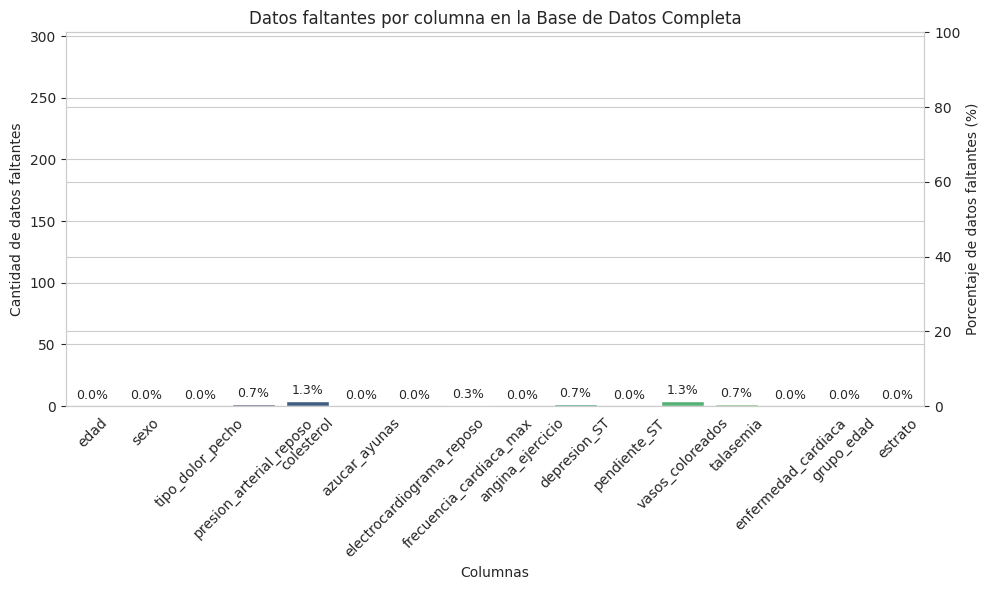

In [ ]:
# Gráfico de datos faltantes
fig, ax1 = plt.subplots(figsize=(10, 6))
missing_counts = Cardiopatia_df.isna().sum()
missing_percent = (missing_counts / Cardiopatia_df.shape[0]) * 100

# cantidades absolutas
sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='viridis', ax=ax1)
ax1.set_ylabel('Cantidad de datos faltantes')
ax1.set_xlabel('Columnas')
ax1.set_title('Datos faltantes por columna en la Base de Datos Completa')
ax1.set_ylim(0, Cardiopatia_df.shape[0])
ax1.tick_params(axis='x', rotation=45)

# eje para porcentajes
ax2 = ax1.twinx()
ax2.set_ylabel('Porcentaje de datos faltantes (%)')
ax2.set_ylim(0, 100)

# etiquetas de porcentaje
for i, (count, percent) in enumerate(zip(missing_counts.values, missing_percent.values)):
    ax1.text(i, count + Cardiopatia_df.shape[0] * 0.01, f'{percent:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

#### Desbalanceos en variable objetivo

In [ ]:
# Ya que solo queremos saber si presenta cardiopatia o no, unificamos al resto mientras sean positivos.
Cardiopatia_df['enfermedad_cardiaca'] = (Cardiopatia_df['enfermedad_cardiaca'] > 0).astype(int)

In [ ]:
print("\n🎯 DISTRIBUCIÓN DE LA VARIABLE OBJETIVO (enfermedad_cardiaca) en BD Completo:")
enfermedad_cardiaca_counts = Cardiopatia_df['enfermedad_cardiaca'].value_counts().sort_index()
enfermedad_cardiaca_props = enfermedad_cardiaca_counts / enfermedad_cardiaca_counts.sum()

print("Distribución absoluta:")
print(f"• Sin enfermedad cardiaca (0): {enfermedad_cardiaca_counts[0]} casos")
print(f"• Con enfermedad cardiaca (1): {enfermedad_cardiaca_counts[1]} casos")

print("\nDistribución porcentual:")
print(f"• Sin enfermedad cardiaca (0): {enfermedad_cardiaca_props[0]:.1%}")
print(f"• Con enfermedad cardiaca (1): {enfermedad_cardiaca_props[1]:.1%}")

# Verificar balance de clases
balance_ratio = min(enfermedad_cardiaca_counts) / max(enfermedad_cardiaca_counts)
print(f"• Ratio de balance: {balance_ratio:.2f}")

if balance_ratio < 0.3:
    print("⚠️ Dataset desbalanceado - considerar técnicas de balanceo")
elif balance_ratio < 0.6:
    print("⚡ Dataset moderadamente desbalanceado")
else:
    print("✅ Dataset razonablemente balanceado")


🎯 DISTRIBUCIÓN DE LA VARIABLE OBJETIVO (enfermedad_cardiaca) en BD Completo:
Distribución absoluta:
• Sin enfermedad cardiaca (0): 164 casos
• Con enfermedad cardiaca (1): 139 casos

Distribución porcentual:
• Sin enfermedad cardiaca (0): 54.1%
• Con enfermedad cardiaca (1): 45.9%
• Ratio de balance: 0.85
✅ Dataset razonablemente balanceado


Con una distribución de clases de 54.1% vs 45.9% y un ratio de balance de 0.85, el dataset se considera razonablemente balanceado. Por lo que no es necesario aplicar técnicas de balanceo de clase, en su lugar es recomendable monitorear métricas como precisión, recall y F1-score por clase.

#### Boxplots

In [ ]:
def box_hist_plot(base_de_datos, v_objetivo, variable):
  """
  Visualiza la distribución de una variable numérica por clase de enfermedad cardíaca.

  Parámetros:
  - base_de_datos: DataFrame que contiene los datos.
  - v_objetivo: nombre de la variable objetivo (por ejemplo, 'enfermedad_cardiaca').
  - variable: nombre de la variable numérica a graficar.

  Salida:
  - Muestra dos gráficos por clase (sin/con enfermedad): boxplot y histograma con líneas de media, mediana, moda y desviación estándar.
  """

  plt.rcParams['axes.facecolor'] = '#D6F3FF'

  fig, axes = plt.subplots(2, 2, figsize=(12, 5.6))  # 2 filas, 2 columnas

  for col in base_de_datos[v_objetivo].unique():

    plot_dat = base_de_datos[base_de_datos[v_objetivo] == col][variable]
    if col == 0:
      S_C = "sin"
    else:
      S_C = "con"

    mean_value = plot_dat.mean()
    median_value = plot_dat.median()
    mode_value = plot_dat.mode().values[0]
    std_value = plot_dat.std()

    sns.boxplot(x=plot_dat, ax=axes[0][col], color='#45b1e8')

    axes[0][col].axvline(mean_value, color='b', linestyle='-', linewidth=2, label=f'Media: {mean_value:.2f}')
    axes[0][col].axvline(median_value, color='r', linestyle='-', linewidth=2, label=f'Mediana: {median_value:.2f}')
    axes[0][col].axvline(mode_value, color='m', linestyle='-', linewidth=2, label=f'Moda: {mode_value:.2f}')
    axes[0][col].axvline(mean_value + std_value, color='b', linestyle='dashed', linewidth=2, label=f'Std ±: {std_value:.2f}')
    axes[0][col].axvline(mean_value - std_value, color='b', linestyle='dashed')

    axes[0][col].set_title(f"Grafico de cajas de {variable} {S_C} enfermedad cardiaca")
    axes[0][col].set_xlabel("")
    axes[0][col].legend(loc='upper left')

    sns.histplot(plot_dat, kde=True, color='#45b1e8', ax=axes[1][col])

    axes[1][col].axvline(mean_value, color='b', linestyle='-', linewidth=2)
    axes[1][col].axvline(median_value, color='r', linestyle='-', linewidth=2)
    axes[1][col].axvline(mode_value, color='m', linestyle='-', linewidth=2)
    axes[1][col].axvline(mean_value + std_value, color='b', linestyle='dashed')
    axes[1][col].axvline(mean_value - std_value, color='b', linestyle='dashed')

    axes[1][col].set_xlabel(f"{variable} {S_C} enfermedad cardiaca")
    axes[1][col].set_ylabel("Densidad")

  plt.tight_layout()
  plt.show()


--------------------------------------------------------------------------------
                         📊 Visualizando variable: EDAD                          
--------------------------------------------------------------------------------


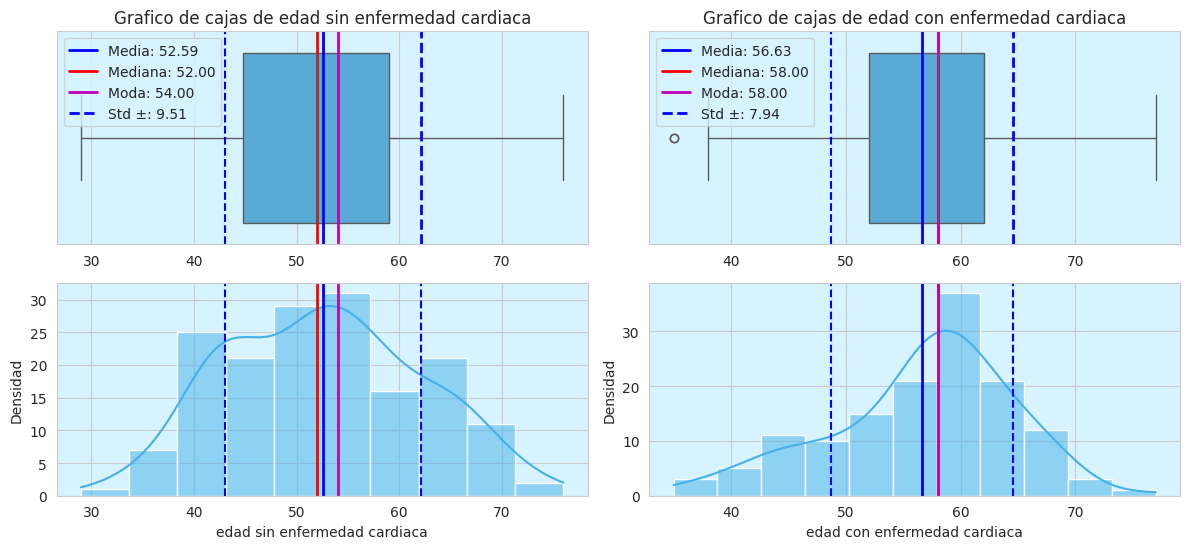

--------------------------------------------------------------------------------
                📊 Visualizando variable: PRESION_ARTERIAL_REPOSO                
--------------------------------------------------------------------------------


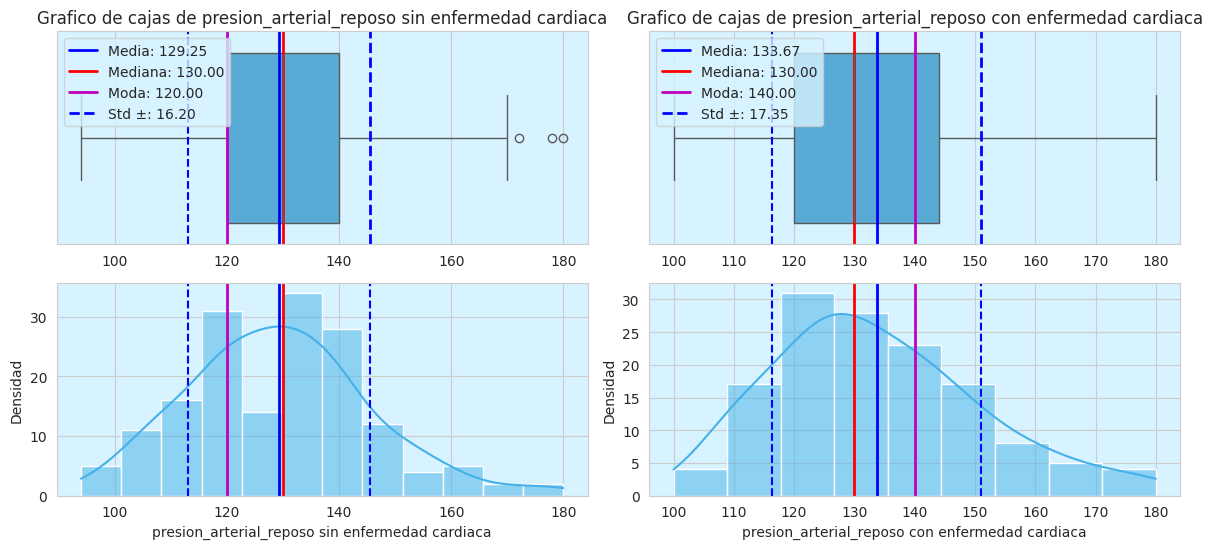

--------------------------------------------------------------------------------
                      📊 Visualizando variable: COLESTEROL                       
--------------------------------------------------------------------------------


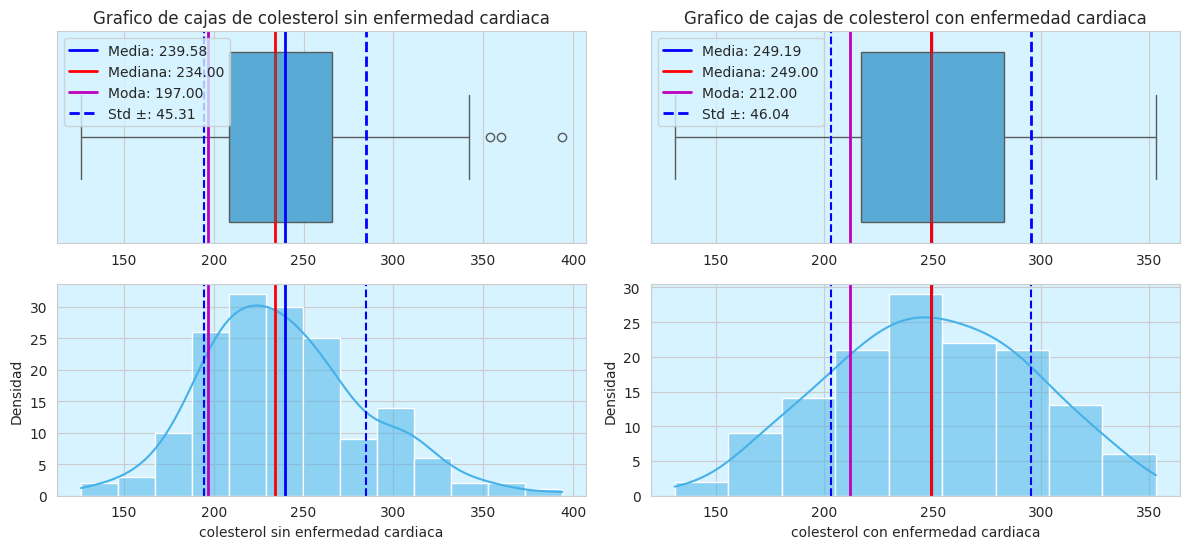

--------------------------------------------------------------------------------
                📊 Visualizando variable: FRECUENCIA_CARDIACA_MAX                
--------------------------------------------------------------------------------


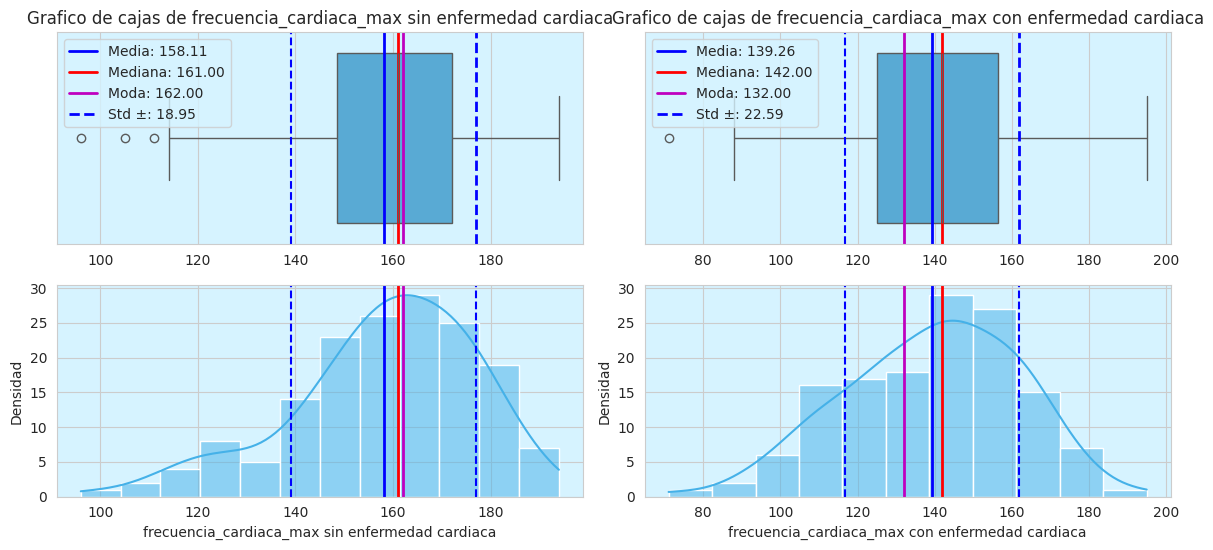

--------------------------------------------------------------------------------
                     📊 Visualizando variable: DEPRESION_ST                      
--------------------------------------------------------------------------------


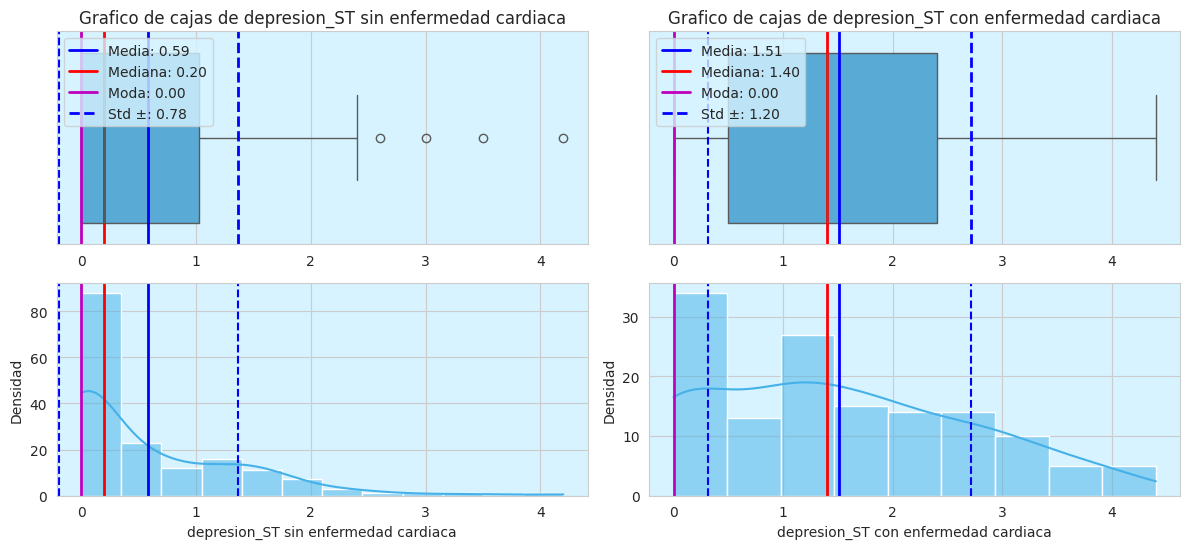

In [ ]:
# Seleccionar variables numéricas excepto enfermedad_cardiaca
variables = Cardiopatia_df[["edad", "presion_arterial_reposo", "colesterol", "frecuencia_cardiaca_max", "depresion_ST"]]

# Graficar cada variable
for var in variables:
  titulo = f"📊 Visualizando variable: {var.upper()}"
  print("-"*80 + "\n" + titulo.center(80, " ") + "\n" + "-"*80)

  box_hist_plot(Cardiopatia_df, v_objetivo= "enfermedad_cardiaca", variable= var)

#### Identificación de correlaciones bivariadas

Text(0.5, 1.0, 'Correlación de Pearson')

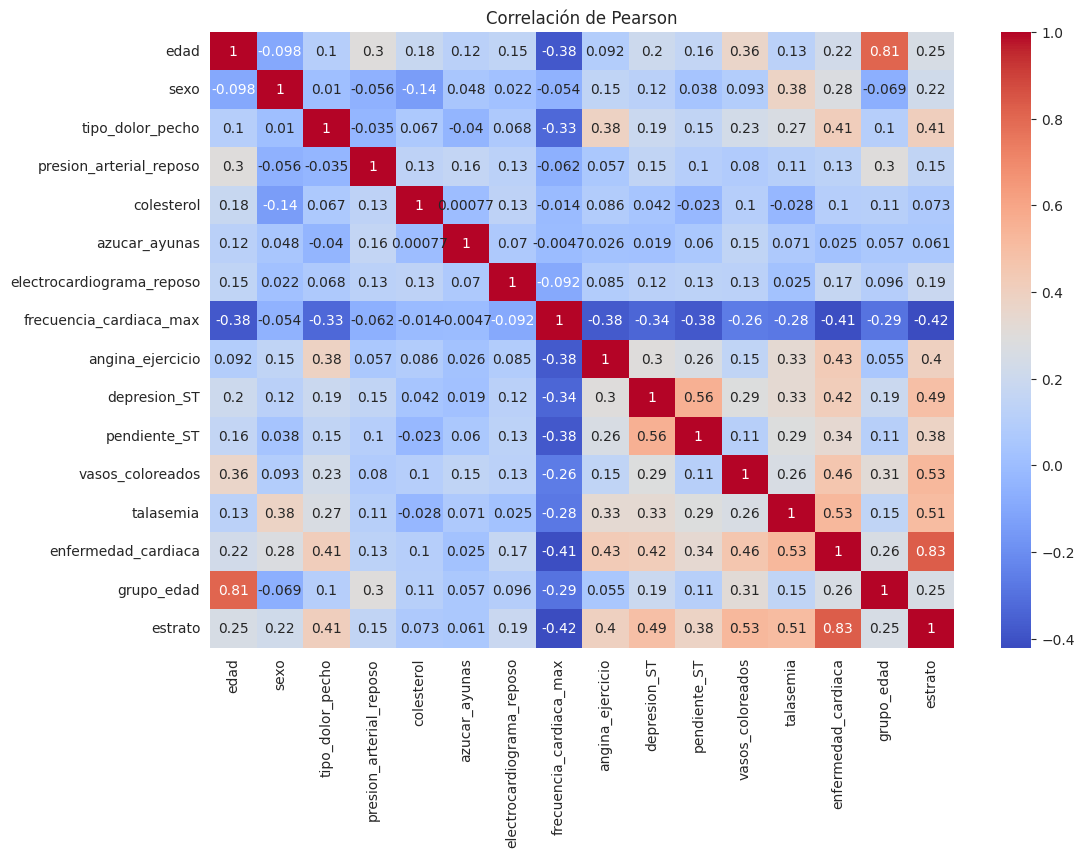

In [ ]:
# Correlación de Pearson entre variables numéricas
correlaciones = Cardiopatia_df.corr(method='pearson')
sns.heatmap(correlaciones, annot=True, cmap='coolwarm')
plt.title(f'Correlación de Pearson')

In [ ]:
# ========================
# Identificar correlaciones altas
# ========================
# Tomamos la parte superior de la matriz (sin diagonal)
high_corr_pairs = (
    correlaciones.where(np.triu(np.ones(correlaciones.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr_pairs.columns = ["Var1", "Var2", "Corr"]

# Ordenar por correlación descendente
high_corr_pairs = high_corr_pairs.sort_values(by="Corr", ascending=False)
high_corr_pairs = high_corr_pairs.reindex(high_corr_pairs["Corr"].abs().sort_values(ascending=False).index)

# Filtrar correlaciones
high_corr_pairs_filter = high_corr_pairs.loc[high_corr_pairs["Corr"].abs() > 0.3]

if not high_corr_pairs_filter.empty:
  print("\n  ORDENANDO CORRELACIONES ALTAS:")
  high_corr_pairs_filter.apply(
      lambda row: print(f"  • {row['Var1']} vs {row['Var2']}: {row['Corr']:.3f}"),
      axis=1
  )


  ORDENANDO CORRELACIONES ALTAS:
  • enfermedad_cardiaca vs estrato: 0.833
  • edad vs grupo_edad: 0.808
  • depresion_ST vs pendiente_ST: 0.557
  • vasos_coloreados vs estrato: 0.527
  • talasemia vs enfermedad_cardiaca: 0.526
  • talasemia vs estrato: 0.511
  • depresion_ST vs estrato: 0.494
  • vasos_coloreados vs enfermedad_cardiaca: 0.460
  • angina_ejercicio vs enfermedad_cardiaca: 0.432
  • depresion_ST vs enfermedad_cardiaca: 0.421
  • frecuencia_cardiaca_max vs estrato: -0.421
  • tipo_dolor_pecho vs enfermedad_cardiaca: 0.414
  • frecuencia_cardiaca_max vs enfermedad_cardiaca: -0.414
  • tipo_dolor_pecho vs estrato: 0.407
  • angina_ejercicio vs estrato: 0.396
  • tipo_dolor_pecho vs angina_ejercicio: 0.384
  • frecuencia_cardiaca_max vs pendiente_ST: -0.382
  • sexo vs talasemia: 0.381
  • edad vs frecuencia_cardiaca_max: -0.381
  • pendiente_ST vs estrato: 0.379
  • frecuencia_cardiaca_max vs angina_ejercicio: -0.376
  • edad vs vasos_coloreados: 0.363
  • pendiente_ST vs 

Aunque las correlaciones entre las variables independientes no son particularmente altas, lo que sugiere una baja probabilidad de multicolinealidad. De igual forma se recomienda aplicar VIF, ya que permite confirmar la estabilidad de los coeficientes y garantizar que no existen relaciones ocultas que puedan distorsionar la interpretación del modelo.

In [ ]:
# Filtrar correlaciones con la variable dependiente
dependiente = "enfermedad_cardiaca"
high_corr_dependiente = high_corr_pairs[
    (high_corr_pairs["Var1"] == dependiente) | (high_corr_pairs["Var2"] == dependiente)
]

if not high_corr_dependiente.empty:
    print("\n  CORRELACIONES CON LA VARIABLE DEPENDIENTE:")
    high_corr_dependiente.apply(
        lambda row: print(f"  • {row['Var1']} vs {row['Var2']}: {row['Corr']:.3f}"),
        axis=1
    )


  CORRELACIONES CON LA VARIABLE DEPENDIENTE:
  • enfermedad_cardiaca vs estrato: 0.833
  • talasemia vs enfermedad_cardiaca: 0.526
  • vasos_coloreados vs enfermedad_cardiaca: 0.460
  • angina_ejercicio vs enfermedad_cardiaca: 0.432
  • depresion_ST vs enfermedad_cardiaca: 0.421
  • tipo_dolor_pecho vs enfermedad_cardiaca: 0.414
  • frecuencia_cardiaca_max vs enfermedad_cardiaca: -0.414
  • pendiente_ST vs enfermedad_cardiaca: 0.339
  • sexo vs enfermedad_cardiaca: 0.277
  • enfermedad_cardiaca vs grupo_edad: 0.256
  • edad vs enfermedad_cardiaca: 0.223
  • electrocardiograma_reposo vs enfermedad_cardiaca: 0.169
  • presion_arterial_reposo vs enfermedad_cardiaca: 0.131
  • colesterol vs enfermedad_cardiaca: 0.105
  • azucar_ayunas vs enfermedad_cardiaca: 0.025


Se considera la utilisacion de todas las variables ya que se evalua la aplicacion del VIF para detectar redundancias entre independientes. Con el objetivo de depurar el modelo y preservar la estabilidad de los coeficientes.

## Modify (Modificación)

### Limpieza de datos

In [ ]:
y_train = (y_train > 0).astype(int)
y_test = (y_test > 0).astype(int)

In [ ]:
# Unificar X e y antes de pasar al transformador
df_temp_train = X_train.copy()
df_temp_train["enfermedad_cardiaca"] = y_train

df_temp_test = X_test.copy()
df_temp_test["enfermedad_cardiaca"] = y_test

#### aplicar_filtro_rangos

In [ ]:
# Aplicar filtro solo a X
df_limpio = aplicar_filtro_rangos(df_temp_train, rangos_validos)

##### Paso 1 del Pipeline

In [ ]:
class FiltroRangos(BaseEstimator, TransformerMixin):
    def __init__(self, rangos_validos, verbose=False):
        self.rangos_validos = rangos_validos
        self.verbose = verbose

    def fit(self, X, y=None):
        # No necesita aprender nada, solo guardar rangos
        return self

    def transform(self, X):
        df_filtrado = aplicar_filtro_rangos(X, self.rangos_validos, verbose=self.verbose)
        return df_filtrado

#### Imputación de valores faltantes

##### Metodo MICE

In [ ]:
def imputacion_mice_manual(df, columnas_categoricas, agrupadores=["sexo", "edad"], n_iteraciones=5, verbose=False):
    """
    Imputa valores faltantes en un DataFrame usando una estrategia MICE manual.

    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame con valores faltantes.
    columnas_categoricas : list
        Lista de columnas categóricas a imputar con moda y redondear al final.
    agrupadores : list, opcional
        Columnas por las que se agrupa para imputar medianas.
    n_iteraciones : int, opcional
        Número de iteraciones para imputación por regresión.
    verbose : bool, opcional
        Si es True, imprime detalles del proceso.

    Retorna:
    --------
    df_imputado : pandas.DataFrame
        DataFrame con valores imputados.
    """
    df = df.copy()

    # Paso 1: Imputar categóricas con moda
    for col in columnas_categoricas:
        moda = df[col].mode(dropna=True)[0]
        df[col] = df[col].fillna(moda)
        if verbose:
            print(f"Moda imputada en '{col}': {moda}")

    # Paso 2: Imputar numéricas por mediana agrupada
    columnas_con_nulos = df.columns[df.isnull().any()]
    for col in columnas_con_nulos:
        if df[col].dtype in ["float64", "int64"]:
            df[col] = df.groupby(agrupadores)[col].transform(lambda x: x.fillna(x.median()))
            if verbose:
                print(f"Mediana agrupada imputada en '{col}'")

    # Paso 3: Imputación preventiva con mediana global
    df = df.fillna(df.median(numeric_only=True))
    if verbose:
        print("Imputación preventiva con mediana global aplicada.")

    # Paso 4: Iteraciones MICE manual por regresión
    for iteracion in range(n_iteraciones):
        if verbose:
            print(f"\nIteración {iteracion + 1} de imputación por regresión:")

        for col in columnas_con_nulos:
            df_temp = df.copy()
            y = df_temp[col]
            X = df_temp.drop(columns=[col])

            # Filas con y no nulo
            mask = ~y.isnull()
            y_train = y[mask]
            X_train = X[mask]

            # Reentrenar modelo
            modelo = sm.OLS(y_train, sm.add_constant(X_train)).fit()

            # Predecir valores faltantes
            X_pred = sm.add_constant(X[~mask])
            y_pred = modelo.predict(X_pred)

            # Imputar
            df.loc[~mask, col] = y_pred

            if verbose:
                print(f"  → Imputado '{col}' con regresión lineal.")

    # Paso 5: Redondear categóricas imputadas
    for col in columnas_categoricas:
        df[col] = df[col].round().astype(int)
        if verbose:
            print(f"Valores redondeados en '{col}': {df[col].unique()}")

    if verbose:
        print("\nImputación MICE manual completada.")
        print("Resumen de valores faltantes:")
        print(df.isnull().sum())

    return df

In [ ]:
columnas_categoricas = ["vasos_coloreados", "talasemia"]
df_limpio = imputacion_mice_manual(df_limpio, columnas_categoricas, verbose=True)

Moda imputada en 'vasos_coloreados': 0.0
Moda imputada en 'talasemia': 3.0
Mediana agrupada imputada en 'presion_arterial_reposo'
Mediana agrupada imputada en 'colesterol'
Mediana agrupada imputada en 'depresion_ST'
Imputación preventiva con mediana global aplicada.

Iteración 1 de imputación por regresión:
  → Imputado 'presion_arterial_reposo' con regresión lineal.
  → Imputado 'colesterol' con regresión lineal.
  → Imputado 'depresion_ST' con regresión lineal.

Iteración 2 de imputación por regresión:
  → Imputado 'presion_arterial_reposo' con regresión lineal.
  → Imputado 'colesterol' con regresión lineal.
  → Imputado 'depresion_ST' con regresión lineal.

Iteración 3 de imputación por regresión:
  → Imputado 'presion_arterial_reposo' con regresión lineal.
  → Imputado 'colesterol' con regresión lineal.
  → Imputado 'depresion_ST' con regresión lineal.

Iteración 4 de imputación por regresión:
  → Imputado 'presion_arterial_reposo' con regresión lineal.
  → Imputado 'colesterol' c

###### Paso 2 del Pipeline

In [ ]:
class ImputacionMICE(BaseEstimator, TransformerMixin):
    def __init__(self, columnas_categoricas, n_iteraciones=5, verbose=False):
        self.columnas_categoricas = columnas_categoricas
        self.n_iteraciones = n_iteraciones
        self.verbose = verbose

    def fit(self, X, y=None):
        # No necesita aprender nada, solo estructura
        return self

    def transform(self, X):
        df_imputado = imputacion_mice_manual(
            X,
            columnas_categoricas=self.columnas_categoricas,
            n_iteraciones=self.n_iteraciones,
            verbose=self.verbose
        )
        return df_imputado

#### Conversión de columnas categóricas

##### Paso 3 del Pipeline

In [ ]:
class ConvertirCateg(BaseEstimator, TransformerMixin):
    def __init__(self, columnas_numericas, verbose=False):
        self.columnas_numericas = columnas_numericas
        self.verbose = verbose

    def fit(self, X, y=None):
        # No necesita aprender nada, solo guardar columnas categóricas
        self.columnas_categoricas_ = [col for col in X.columns if col not in self.columnas_numericas]
        return self

    def transform(self, X):
        df = X.copy()
        df[self.columnas_categoricas_] = df[self.columnas_categoricas_].astype("category")
        if self.verbose:
            print(f"Columnas convertidas a categóricas: {self.columnas_categoricas_}")
        return df

In [ ]:
v = ["edad", "presion_arterial_reposo", "colesterol", "frecuencia_cardiaca_max", "depresion_ST", "enfermedad_cardiaca"]

# Instanciar el transformador
categoricas = ConvertirCateg(columnas_numericas= v, verbose=True)

# Ajustar con train
categoricas.fit(df_limpio)

# Transformar train y ver resultados
df = categoricas.transform(df_limpio)

Columnas convertidas a categóricas: ['sexo', 'tipo_dolor_pecho', 'azucar_ayunas', 'electrocardiograma_reposo', 'angina_ejercicio', 'pendiente_ST', 'vasos_coloreados', 'talasemia', 'grupo_edad']


#### Tratamiento de outliers

##### Paso 4 del Pipeline

In [ ]:
class OutlierIQR(BaseEstimator, TransformerMixin):
    def __init__(self, clase=None, verbose=False):
        self.clase = clase
        self.verbose = verbose
        self.limites_ = {}

    def fit(self, X, y=None):
        df = X.copy()

        # Si se especifica una columna de clase que está en X
        if self.clase is not None and self.clase in df.columns:
            for valor in df[self.clase].unique():
                df_clase = df[df[self.clase] == valor]
                columnas_numericas = df_clase.select_dtypes(include=['int64','float64']).columns.tolist()
                columnas_numericas = [c for c in columnas_numericas if c != self.clase]

                for col in columnas_numericas:
                    Q1 = df_clase[col].quantile(0.25)
                    Q3 = df_clase[col].quantile(0.75)
                    IQR = Q3 - Q1
                    li = Q1 - 1.5 * IQR
                    ls = Q3 + 1.5 * IQR
                    self.limites_[(col, valor)] = (li, ls)
                    if self.verbose:
                        print(f"{col} (Clase {valor}): límites = [{li:.2f}, {ls:.2f}]")
        else:
            # Global
            columnas_numericas = df.select_dtypes(include=['int64','float64']).columns.tolist()
            for col in columnas_numericas:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                li = Q1 - 1.5 * IQR
                ls = Q3 + 1.5 * IQR
                self.limites_[col] = (li, ls)
                if self.verbose:
                    print(f"{col}: límites = [{li:.2f}, {ls:.2f}]")
        return self

    def transform(self, X):
        df = X.copy()
        if any(isinstance(k, tuple) for k in self.limites_.keys()):
            # aplicar por clase (si la columna está en X)
            for (col, valor), (li, ls) in self.limites_.items():
                if self.clase in df.columns:
                    mask = df[self.clase] == valor
                    df.loc[mask, col] = df.loc[mask, col].clip(lower=li, upper=ls)
        else:
            # aplicar global
            for col, (li, ls) in self.limites_.items():
                df[col] = df[col].clip(lower=li, upper=ls)
        return df

In [ ]:
def plot_transform(df, transformed_df, variable):
  """
  Compara visualmente una variable antes y después de su transformación.

  Parámetros:
  - df: DataFrame original antes de la transformación.
  - transformed_df: DataFrame con la variable ya transformada.
  - variable: nombre de la variable numérica a comparar.

  Salida:
  - Muestra cuatro gráficos: boxplot y histograma (con KDE) para la versión original y transformada de la variable.
  """

  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

  sns.boxplot(x=df[variable], ax=axes[0, 0], color='#00308F')
  axes[0, 0].set_title(f"{variable} original")

  sns.boxplot(x=transformed_df[variable], ax=axes[0, 1], color='#7CB9E8')
  axes[0, 1].set_title(f"{variable} transformada")

  sns.histplot(df[variable], ax=axes[1, 0], kde=True, color='#00308F')
  axes[1, 0].set_title(f"Distribución de {variable} original")

  sns.histplot(transformed_df[variable], ax=axes[1, 1], kde=True, color='#7CB9E8')
  axes[1, 1].set_title(f"Distribución de {variable} transformada")

  plt.tight_layout()
  plt.show()

In [ ]:
# Instanciar el transformador
outlier_step = OutlierIQR(clase="enfermedad_cardiaca", verbose=True)

# Ajustar con train
outlier_step.fit(df_limpio)

# Transformar train y ver resultados
df_limpio = outlier_step.transform(df_limpio)

edad (Clase 0): límites = [22.25, 80.25]
sexo (Clase 0): límites = [-1.50, 2.50]
tipo_dolor_pecho (Clase 0): límites = [-0.25, 5.75]
presion_arterial_reposo (Clase 0): límites = [90.00, 170.00]
colesterol (Clase 0): límites = [120.50, 352.50]
azucar_ayunas (Clase 0): límites = [0.00, 0.00]
electrocardiograma_reposo (Clase 0): límites = [-3.00, 5.00]
frecuencia_cardiaca_max (Clase 0): límites = [113.25, 207.25]
angina_ejercicio (Clase 0): límites = [0.00, 0.00]
depresion_ST (Clase 0): límites = [-1.50, 2.50]
pendiente_ST (Clase 0): límites = [-0.50, 3.50]
vasos_coloreados (Clase 0): límites = [0.00, 0.00]
talasemia (Clase 0): límites = [3.00, 3.00]
grupo_edad (Clase 0): límites = [-1.50, 2.50]
edad (Clase 1): límites = [37.00, 77.00]
sexo (Clase 1): límites = [1.00, 1.00]
tipo_dolor_pecho (Clase 1): límites = [1.50, 5.50]
presion_arterial_reposo (Clase 1): límites = [97.00, 169.00]
colesterol (Clase 1): límites = [122.00, 378.00]
azucar_ayunas (Clase 1): límites = [0.00, 0.00]
electroca

--------------------------------------------------------------------------------
                         EDAD - Sin enfermedad cardíaca                         
--------------------------------------------------------------------------------


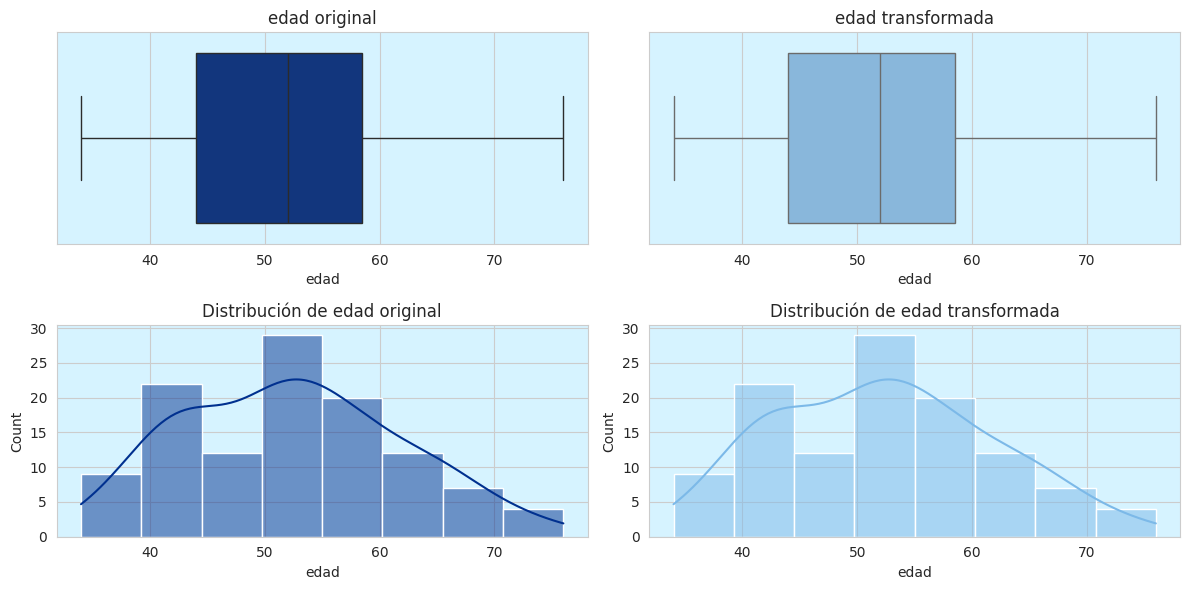

--------------------------------------------------------------------------------
                         EDAD - Con enfermedad cardíaca                         
--------------------------------------------------------------------------------


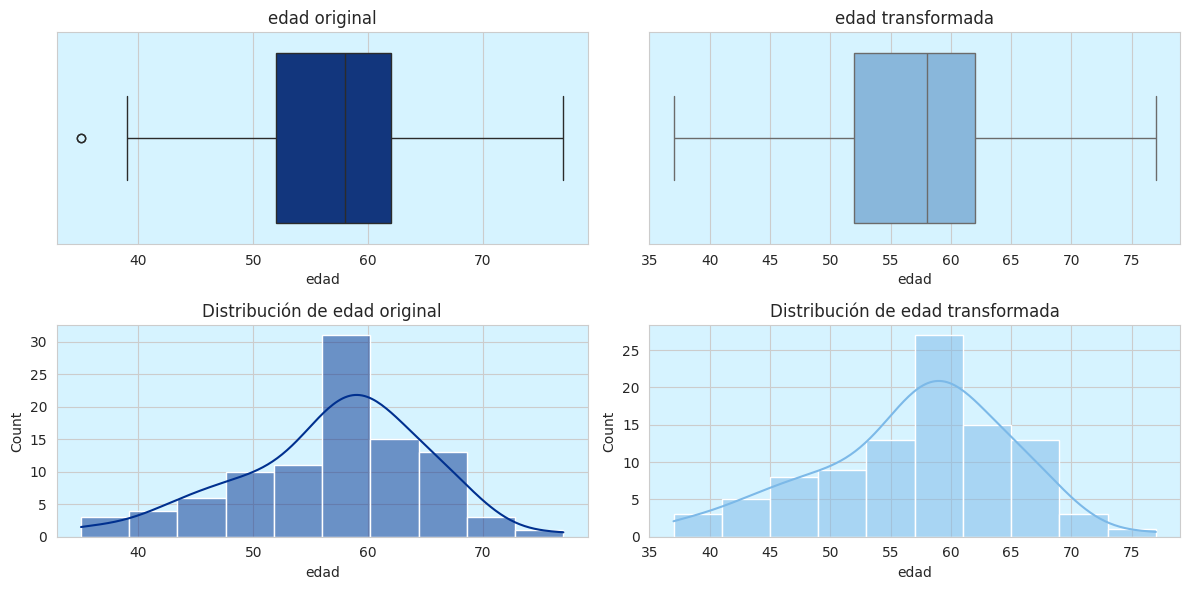

--------------------------------------------------------------------------------
               PRESION_ARTERIAL_REPOSO - Sin enfermedad cardíaca                
--------------------------------------------------------------------------------


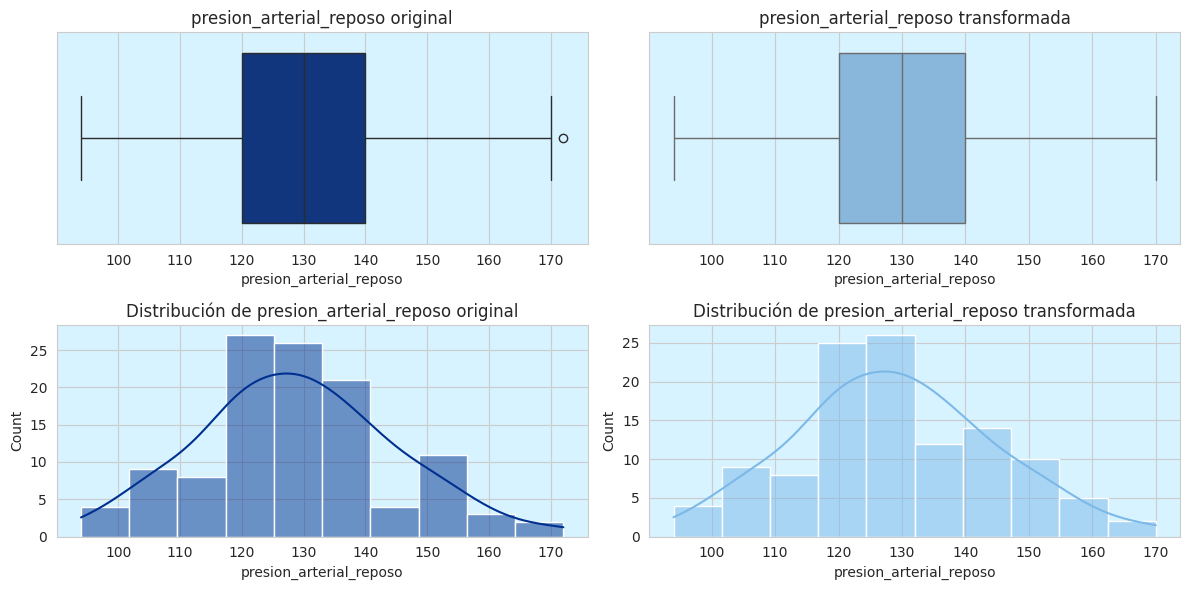

--------------------------------------------------------------------------------
               PRESION_ARTERIAL_REPOSO - Con enfermedad cardíaca                
--------------------------------------------------------------------------------


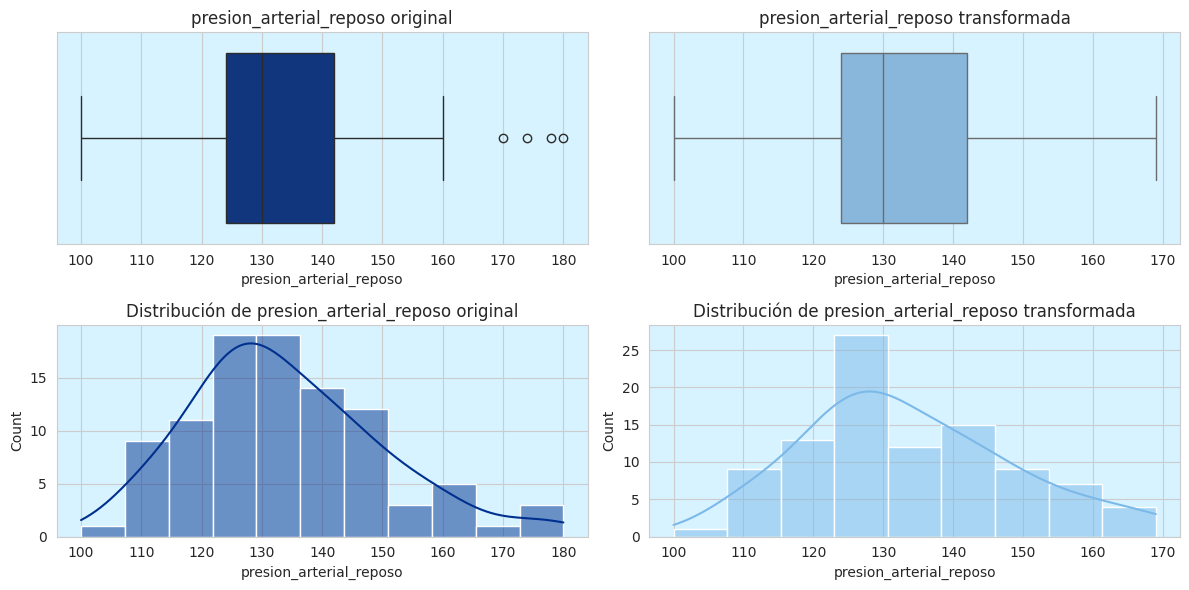

--------------------------------------------------------------------------------
                      COLESTEROL - Sin enfermedad cardíaca                      
--------------------------------------------------------------------------------


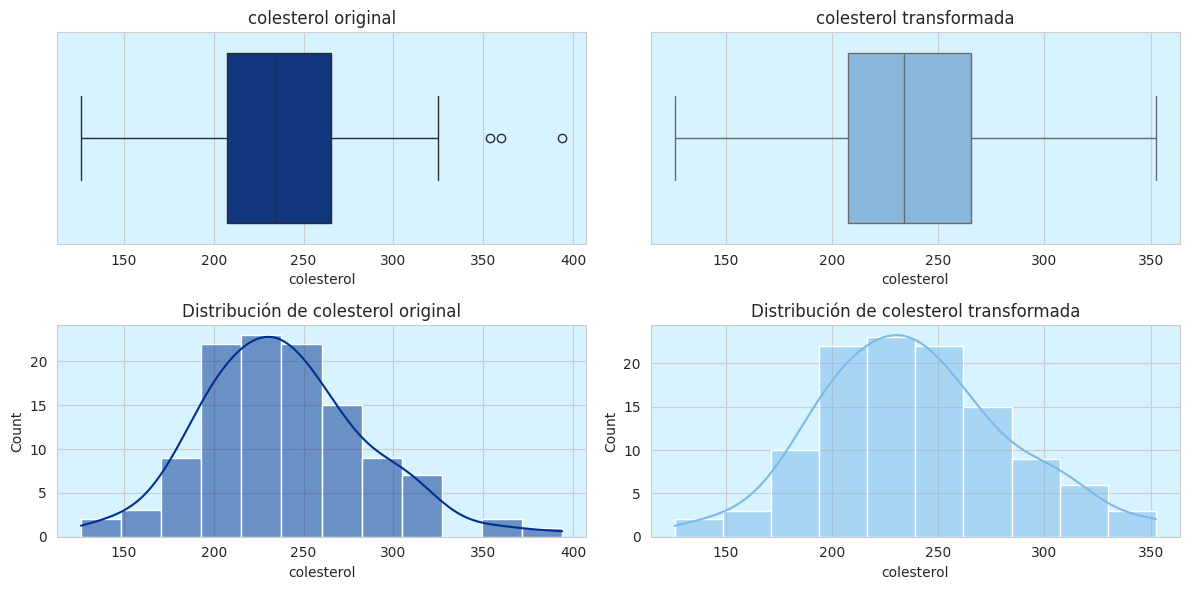

--------------------------------------------------------------------------------
                      COLESTEROL - Con enfermedad cardíaca                      
--------------------------------------------------------------------------------


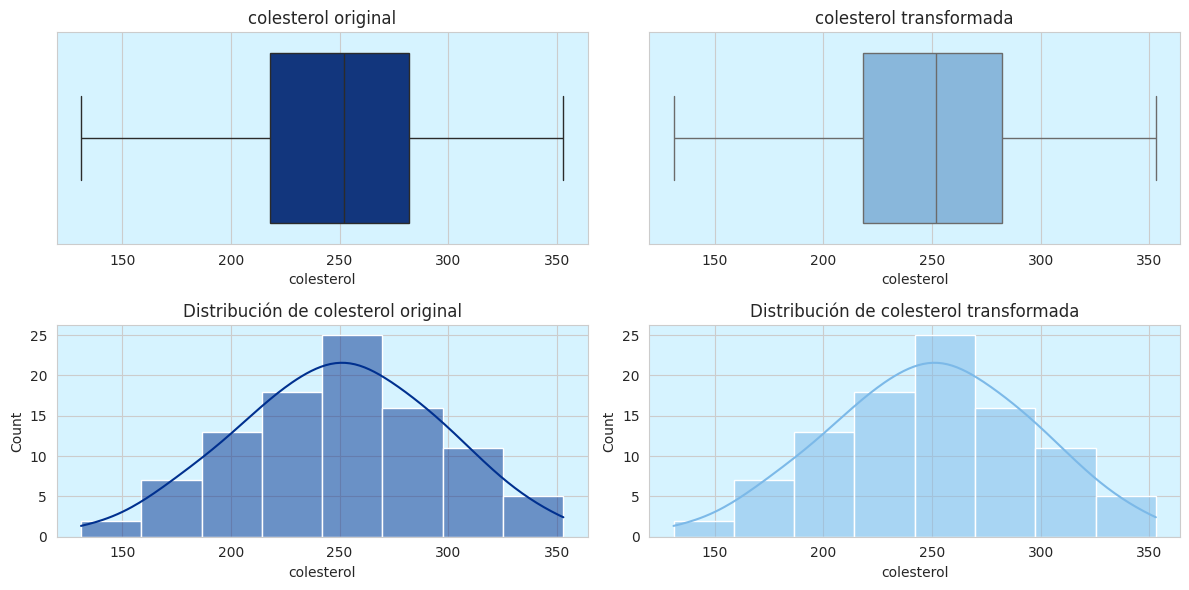

--------------------------------------------------------------------------------
               FRECUENCIA_CARDIACA_MAX - Sin enfermedad cardíaca                
--------------------------------------------------------------------------------


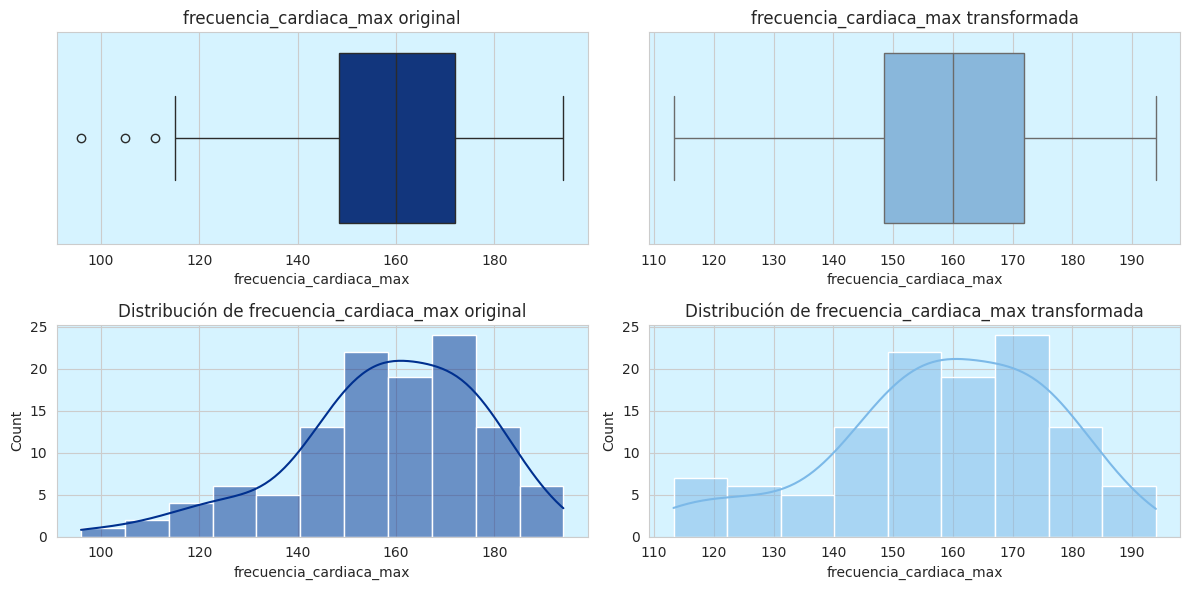

--------------------------------------------------------------------------------
               FRECUENCIA_CARDIACA_MAX - Con enfermedad cardíaca                
--------------------------------------------------------------------------------


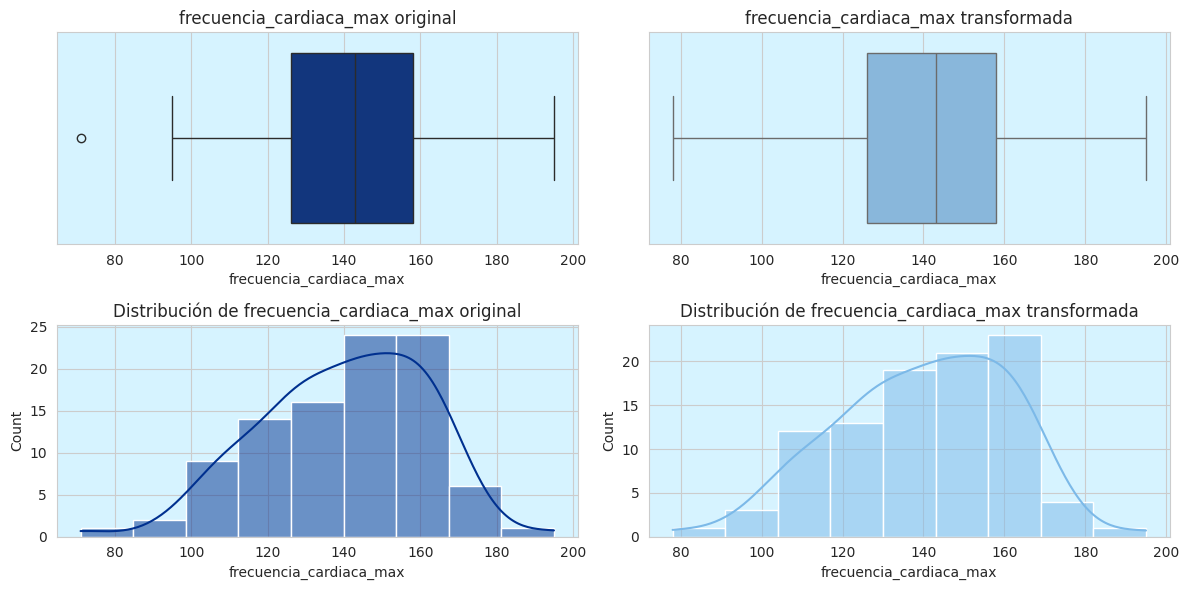

--------------------------------------------------------------------------------
                     DEPRESION_ST - Sin enfermedad cardíaca                     
--------------------------------------------------------------------------------


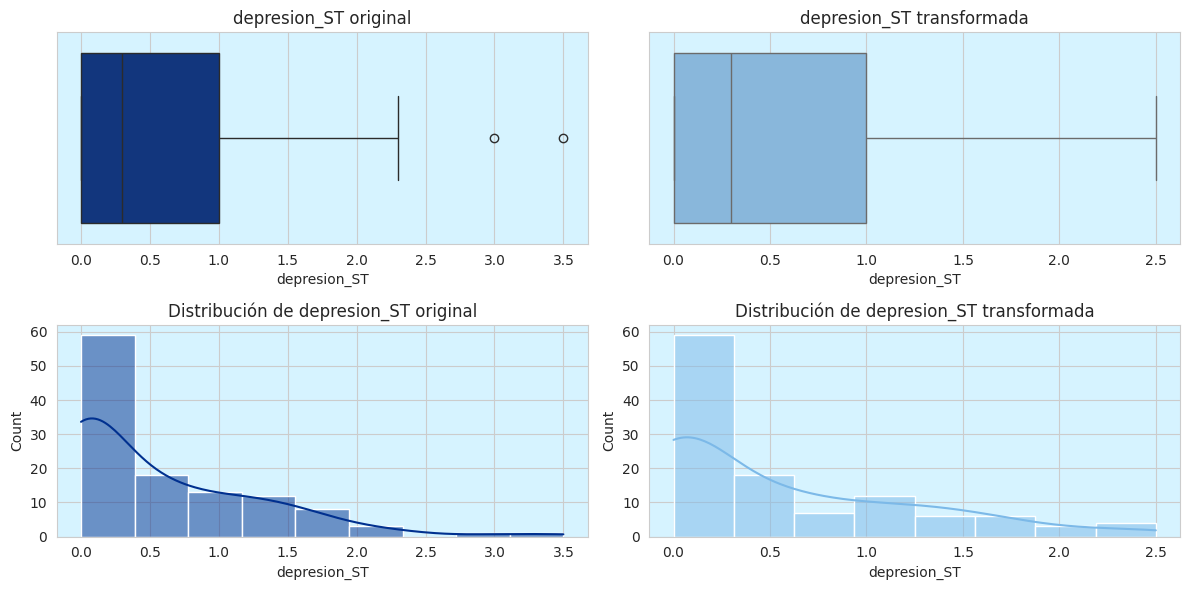

--------------------------------------------------------------------------------
                     DEPRESION_ST - Con enfermedad cardíaca                     
--------------------------------------------------------------------------------


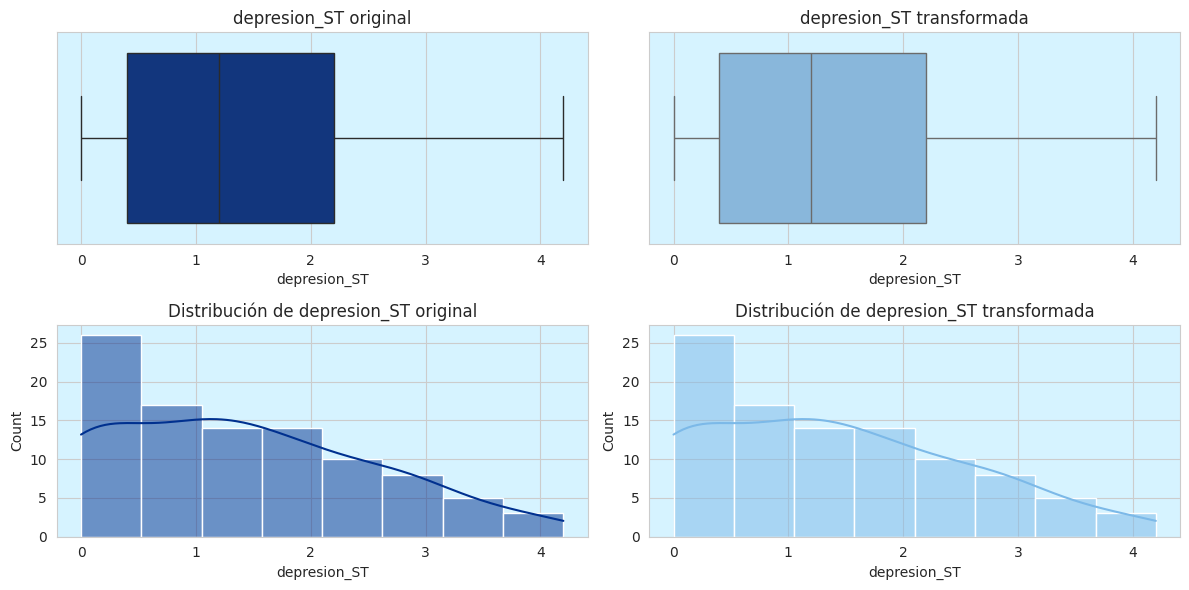

In [ ]:
for variable in v[:-1]:
  for clase in [0, 1]:
    titulo = f"{variable.upper()} - {'Sin' if clase == 0 else 'Con'} enfermedad cardíaca"
    df_filtrado_1 = df[df["enfermedad_cardiaca"] == clase]
    df_filtrado_2 = df_limpio[df_limpio["enfermedad_cardiaca"] == clase]
    print("-"*80 + "\n" + titulo.center(80, " ") + "\n" + "-"*80)
    plot_transform(df_filtrado_1, df_filtrado_2, variable=variable)

In [ ]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212 entries, 233 to 21
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   edad                       212 non-null    int64  
 1   sexo                       212 non-null    int64  
 2   tipo_dolor_pecho           212 non-null    float64
 3   presion_arterial_reposo    212 non-null    float64
 4   colesterol                 212 non-null    float64
 5   azucar_ayunas              212 non-null    int64  
 6   electrocardiograma_reposo  212 non-null    int64  
 7   frecuencia_cardiaca_max    212 non-null    float64
 8   angina_ejercicio           212 non-null    int64  
 9   depresion_ST               212 non-null    float64
 10  pendiente_ST               212 non-null    int64  
 11  vasos_coloreados           212 non-null    int64  
 12  talasemia                  212 non-null    float64
 13  grupo_edad                 212 non-null    int64  
 14

### Transformación de variables

#### Codificación de variables categóricas

Ya que la base de datos presenta a las variables categoricas con "Ordinal Encoding" aplicado. Procedemos a revertir la codificacion, unicamente en las variables categoricas Nominales. Para asi, poder aplicar "One-Hot Encoding".

In [ ]:
a_entero = ["sexo", "presion_arterial_reposo", "colesterol", "azucar_ayunas",
            "frecuencia_cardiaca_max", "angina_ejercicio", "vasos_coloreados"]

# Convertir a tipo entero
df_limpio[a_entero] = df_limpio[a_entero].astype("int")

##### One-Hot Encoding

In [ ]:
# Revertir codificación
df_limpio["tipo_dolor_pecho"] = df_limpio["tipo_dolor_pecho"].map(
    {1: "asintomático", 2: "angina típica", 3: "angina atípica", 4: "dolor no anginoso"})

df_limpio["electrocardiograma_reposo"] = df_limpio["electrocardiograma_reposo"].map(
    {0: "Normal", 1: "Anomalías ST-T", 2: "Hipertrofia ventricular izquierda"})

df_limpio["pendiente_ST"] = df_limpio["pendiente_ST"].map(
    {1: "ascendente", 2: "plano", 3: "descendente"})

df_limpio["talasemia"] = df_limpio["talasemia"].map(
    {3: "normal", 6: "defecto fijo", 7: "defecto reversible"})

# Aplicar One-Hot Encoding
df_limpio = pd.get_dummies(df_limpio, columns=["tipo_dolor_pecho"], drop_first=True)
df_limpio = pd.get_dummies(df_limpio, columns=["electrocardiograma_reposo"], drop_first=True)
df_limpio = pd.get_dummies(df_limpio, columns=["pendiente_ST"], drop_first=True)
df_limpio = pd.get_dummies(df_limpio, columns=["talasemia"], drop_first=True)

df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212 entries, 233 to 21
Data columns (total 20 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   edad                                                         212 non-null    int64  
 1   sexo                                                         212 non-null    int64  
 2   presion_arterial_reposo                                      212 non-null    int64  
 3   colesterol                                                   212 non-null    int64  
 4   azucar_ayunas                                                212 non-null    int64  
 5   frecuencia_cardiaca_max                                      212 non-null    int64  
 6   angina_ejercicio                                             212 non-null    int64  
 7   depresion_ST                                                 212 non-null    float64

convertimos los booleanos obtenidos en enteros, para evitar futuros errores.

In [ ]:
for col in df_limpio.columns:
    if df_limpio[col].dtype == 'bool':
        df_limpio[col] = df_limpio[col].astype(int)

#### Paso 5 del Pipeline

In [ ]:
class CodificacionCategorica(BaseEstimator, TransformerMixin):
    def __init__(self, columnas_ordinales=None, verbose=False):
        self.columnas_ordinales = columnas_ordinales
        self.verbose = verbose

    def fit(self, X, y=None):
        # No necesita aprender nada, solo guardar estructura
        return self

    def transform(self, X):
        df = X.copy()

        # Paso 1: convertir columnas ordinales a entero
        if self.columnas_ordinales:
            df[self.columnas_ordinales] = df[self.columnas_ordinales].astype("int")
            if self.verbose:
                print(f"Columnas ordinales convertidas a int: {self.columnas_ordinales}")

        # Paso 2: revertir codificación numérica a etiquetas
        df["tipo_dolor_pecho"] = df["tipo_dolor_pecho"].map(
            {1: "asintomático", 2: "angina típica", 3: "angina atípica", 4: "dolor no anginoso"}
        )
        df["electrocardiograma_reposo"] = df["electrocardiograma_reposo"].map(
            {0: "Normal", 1: "Anomalías ST-T", 2: "Hipertrofia ventricular izquierda"}
        )
        df["pendiente_ST"] = df["pendiente_ST"].map(
            {1: "ascendente", 2: "plano", 3: "descendente"}
        )
        df["talasemia"] = df["talasemia"].map(
            {3: "normal", 6: "defecto fijo", 7: "defecto reversible"}
        )

        # Paso 3: aplicar One-Hot Encoding
        df = pd.get_dummies(df, columns=["tipo_dolor_pecho"], drop_first=True)
        df = pd.get_dummies(df, columns=["electrocardiograma_reposo"], drop_first=True)
        df = pd.get_dummies(df, columns=["pendiente_ST"], drop_first=True)
        df = pd.get_dummies(df, columns=["talasemia"], drop_first=True)

        # Paso 4: convertir booleanos a enteros
        for col in df.columns:
            if df[col].dtype == "bool":
                df[col] = df[col].astype(int)

        if self.verbose:
            print("Codificación categórica completada.")
            print(df.info())

        return df

#### Normalización/Estandarización de variables numéricas

##### Paso 6 del Pipeline

In [ ]:
class EscaladoEstandar(BaseEstimator, TransformerMixin):
    def __init__(self, exclude=None, verbose=False):
        self.exclude = exclude if exclude is not None else []
        self.verbose = verbose
        self.scaler = StandardScaler()
        self.columns_ = None

    def fit(self, X, y=None):
        df = X.copy()
        # columnas a escalar (todas menos las excluidas)
        self.columns_ = [c for c in df.columns if c not in self.exclude]
        self.scaler.fit(df[self.columns_])
        if self.verbose:
            print(f"Scaler ajustado con columnas: {self.columns_}")
        return self

    def transform(self, X):
        df = X.copy()
        # escalar solo las columnas seleccionadas
        df_scaled = self.scaler.transform(df[self.columns_])
        df[self.columns_] = df_scaled
        return df

### Pipeline Completo

In [ ]:
# Definir el pipeline con los pasos de Modify
pipeline_modify = Pipeline([
    ("filtro_rangos", FiltroRangos(rangos_validos=rangos_validos, verbose=True)),
    ("imputacion_mice", ImputacionMICE(columnas_categoricas=["vasos_coloreados", "talasemia"], verbose=True)),
    ("convertir_categ", ConvertirCateg(columnas_numericas=["edad", "presion_arterial_reposo",
                                                           "colesterol", "frecuencia_cardiaca_max",
                                                           "depresion_ST", "enfermedad_cardiaca"], verbose=True)),
    ("outliers", OutlierIQR(clase="enfermedad_cardiaca", verbose=True)),
    ("codificacion", CodificacionCategorica(
        columnas_ordinales=["sexo", "presion_arterial_reposo", "colesterol", "azucar_ayunas",
                            "frecuencia_cardiaca_max", "angina_ejercicio", "vasos_coloreados"],
        verbose=True
    )),
    ("escalado", EscaladoEstandar(exclude=["enfermedad_cardiaca"], verbose=True))
])

In [ ]:
Xc_tr = pipeline_modify.fit_transform(df_temp_train)

edad                         0
sexo                         0
tipo_dolor_pecho             0
presion_arterial_reposo      1
colesterol                   2
azucar_ayunas                0
electrocardiograma_reposo    0
frecuencia_cardiaca_max      0
angina_ejercicio             0
depresion_ST                 1
pendiente_ST                 0
vasos_coloreados             3
talasemia                    1
grupo_edad                   0
enfermedad_cardiaca          0
dtype: int64
Moda imputada en 'vasos_coloreados': 0.0
Moda imputada en 'talasemia': 3.0
Mediana agrupada imputada en 'presion_arterial_reposo'
Mediana agrupada imputada en 'colesterol'
Mediana agrupada imputada en 'depresion_ST'
Imputación preventiva con mediana global aplicada.

Iteración 1 de imputación por regresión:
  → Imputado 'presion_arterial_reposo' con regresión lineal.
  → Imputado 'colesterol' con regresión lineal.
  → Imputado 'depresion_ST' con regresión lineal.

Iteración 2 de imputación por regresión:
  → Imputado

In [ ]:
Xc_te  = pipeline_modify.transform(df_temp_test)

edad                         0
sexo                         0
tipo_dolor_pecho             0
presion_arterial_reposo      1
colesterol                   2
azucar_ayunas                0
electrocardiograma_reposo    0
frecuencia_cardiaca_max      1
angina_ejercicio             0
depresion_ST                 1
pendiente_ST                 0
vasos_coloreados             1
talasemia                    1
grupo_edad                   0
enfermedad_cardiaca          0
dtype: int64
Moda imputada en 'vasos_coloreados': 0.0
Moda imputada en 'talasemia': 3.0
Mediana agrupada imputada en 'presion_arterial_reposo'
Mediana agrupada imputada en 'colesterol'
Mediana agrupada imputada en 'frecuencia_cardiaca_max'
Mediana agrupada imputada en 'depresion_ST'
Imputación preventiva con mediana global aplicada.

Iteración 1 de imputación por regresión:
  → Imputado 'presion_arterial_reposo' con regresión lineal.
  → Imputado 'colesterol' con regresión lineal.
  → Imputado 'frecuencia_cardiaca_max' con regres

In [ ]:
yc_tr =Xc_tr["enfermedad_cardiaca"]
yc_te =Xc_te["enfermedad_cardiaca"]

Xc_tr = Xc_tr.drop(["enfermedad_cardiaca", "grupo_edad"], axis=1)
Xc_te = Xc_te.drop(["enfermedad_cardiaca", "grupo_edad"], axis=1)


print("Train transformado:", Xc_tr.shape)
print("Test transformado:", Xc_te.shape)

Train transformado: (212, 18)
Test transformado: (91, 18)


## Model (Modelado)

### Clustering

El clustering es un método no supervisado que no utiliza la variable objetivo. Dado que el objetivo principal del proyecto es la predicción supervisada de enfermedad cardíaca, el clustering no aporta directamente a la evaluación del desempeño de los modelos. Sin embargo, puede ser útil como análisis exploratorio para identificar subgrupos de pacientes. En este trabajo se priorizan modelos supervisados (Regresión Logística, KNN, RNA) por su capacidad predictiva.

#### PCA

In [ ]:
pca_pipe = make_pipeline(PCA())
pca_pipe.fit(Xc_tr)
modelo_pca = pca_pipe.named_steps['pca']

In [ ]:
pd.DataFrame(data= modelo_pca.components_, columns = Xc_tr.columns, index = [
    'CP1','CP2','CP3','CP4','CP5',
    'CP6','CP7','CP8','CP9','CP10',
    'CP11','CP12', 'CP13','CP14','CP15',
    'CP16','CP17','CP18'])

,edad,sexo,presion_arterial_reposo,colesterol,azucar_ayunas,frecuencia_cardiaca_max,angina_ejercicio,depresion_ST,vasos_coloreados,tipo_dolor_pecho_angina típica,tipo_dolor_pecho_angina atípica,tipo_dolor_pecho_dolor no anginoso,electrocardiograma_reposo_Anomalías ST-T,electrocardiograma_reposo_Hipertrofia ventricular izquierda,pendiente_ST_plano,pendiente_ST_descendente,talasemia_defecto fijo,talasemia_defecto reversible
CP1,-0.260833,-0.077115,-0.145188,-0.056122,-0.028189,0.377362,-0.333553,-0.338338,-0.284069,0.256945,0.189617,-0.375798,-0.047665,-0.125529,-0.322717,0.036444,-0.096715,-0.275883
CP2,0.387782,-0.224989,0.373885,0.050072,0.379843,-0.053120,-0.185239,0.114144,0.105020,-0.156120,0.445335,-0.340273,0.107045,0.174209,0.026088,0.140623,0.135416,-0.179306
CP3,0.137181,-0.179697,0.163774,0.460160,0.141704,0.077951,0.054074,-0.181166,0.062526,0.356073,-0.446676,0.137732,-0.220828,0.384627,-0.136866,-0.035097,0.119925,-0.261121
CP4,-0.063579,0.537076,0.070562,-0.113115,0.296545,0.207439,0.009542,0.117999,0.190367,0.020995,-0.025865,-0.050469,-0.382275,0.103439,-0.290752,0.435426,0.046847,0.267752
CP5,-0.051876,0.173646,0.005964,-0.370717,0.030982,-0.125479,0.066048,0.018896,-0.195133,0.098457,-0.140781,0.010111,0.032201,-0.097185,0.118660,0.068570,0.753789,-0.378300
CP6,0.234384,-0.173656,0.070902,-0.202060,0.069054,-0.055455,-0.066629,0.039946,0.055333,0.311599,-0.325007,0.094532,0.525175,-0.281302,-0.231058,0.446563,-0.160531,0.083286
CP7,-0.188618,-0.309433,-0.167610,0.057023,-0.212888,0.015627,-0.075870,0.195452,-0.219078,-0.413779,0.028889,0.290083,-0.071487,0.279468,-0.116815,0.551968,0.003930,-0.205120
CP8,-0.018788,-0.159321,-0.297460,-0.009260,0.555685,-0.120131,0.249789,-0.413492,0.094309,-0.328203,0.055654,0.235812,-0.015699,-0.244506,-0.284893,-0.083390,0.044603,-0.060454
CP9,-0.246871,-0.020333,0.577413,0.178865,0.205482,0.210174,0.247791,-0.005259,-0.546228,-0.117243,-0.058419,0.080678,0.050343,-0.242918,0.120569,0.039356,-0.040063,0.155408
CP10,-0.141846,0.049913,-0.416193,0.472312,0.171165,-0.221384,0.307865,0.183289,-0.106218,0.298438,0.160572,-0.295909,0.090726,-0.096493,0.233108,0.296208,0.031499,0.010192


Porcentaje de varianza explicada acumulada
[0.18993277 0.28212232 0.36602809 0.44486532 0.51253718 0.57335381
 0.62857157 0.67930227 0.7290004  0.776161   0.81943825 0.85830995
 0.89555632 0.92799853 0.95318349 0.97567439 0.99449231 1.        ]


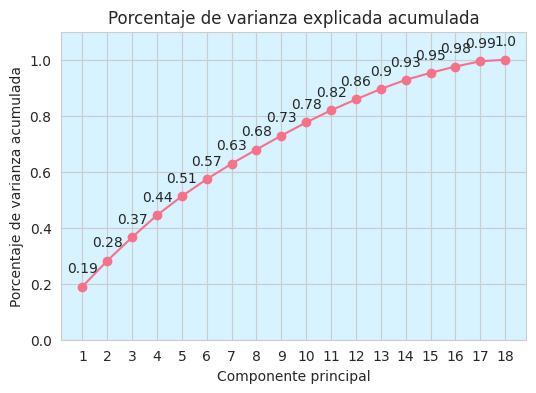

In [ ]:
# Porcentaje de varianza explicada acumulada
por_var_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('Porcentaje de varianza explicada acumulada')
print(por_var_acum)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4))
ax.plot(np.arange(len(Xc_tr.columns)) + 1,por_var_acum, marker='o')

for x, y in zip(np.arange(len(Xc_tr.columns)) + 1, por_var_acum):
  label = round(y,2)
  ax.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha='center')

ax.set_ylim(0,1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Porcentaje de varianza acumulada');

El grafico indica que es suficiente con 11 componentes.

In [ ]:
pca_pipe_final = make_pipeline(PCA(n_components = 11))
pca_pipe_final.fit(Xc_tr)
modelo_pca_final = pca_pipe_final.named_steps['pca']

In [ ]:
X_PCA = pd.DataFrame(data = modelo_pca_final.components_,
                     columns = Xc_tr.columns, index = [
                         'CP1','CP2','CP3','CP4','CP5',
                         'CP6','CP7','CP8','CP9','CP10','CP11'])
X_PCA

,edad,sexo,presion_arterial_reposo,colesterol,azucar_ayunas,frecuencia_cardiaca_max,angina_ejercicio,depresion_ST,vasos_coloreados,tipo_dolor_pecho_angina típica,tipo_dolor_pecho_angina atípica,tipo_dolor_pecho_dolor no anginoso,electrocardiograma_reposo_Anomalías ST-T,electrocardiograma_reposo_Hipertrofia ventricular izquierda,pendiente_ST_plano,pendiente_ST_descendente,talasemia_defecto fijo,talasemia_defecto reversible
CP1,-0.260833,-0.077115,-0.145188,-0.056122,-0.028189,0.377362,-0.333553,-0.338338,-0.284069,0.256945,0.189617,-0.375798,-0.047665,-0.125529,-0.322717,0.036444,-0.096715,-0.275883
CP2,0.387782,-0.224989,0.373885,0.050072,0.379843,-0.053120,-0.185239,0.114144,0.105020,-0.156120,0.445335,-0.340273,0.107045,0.174209,0.026088,0.140623,0.135416,-0.179306
CP3,0.137181,-0.179697,0.163774,0.460160,0.141704,0.077951,0.054074,-0.181166,0.062526,0.356073,-0.446676,0.137732,-0.220828,0.384627,-0.136866,-0.035097,0.119925,-0.261121
CP4,-0.063579,0.537076,0.070562,-0.113115,0.296545,0.207439,0.009542,0.117999,0.190367,0.020995,-0.025865,-0.050469,-0.382275,0.103439,-0.290752,0.435426,0.046847,0.267752
CP5,-0.051876,0.173646,0.005964,-0.370717,0.030982,-0.125479,0.066048,0.018896,-0.195133,0.098457,-0.140781,0.010111,0.032201,-0.097185,0.118660,0.068570,0.753789,-0.378300
CP6,0.234384,-0.173656,0.070902,-0.202060,0.069054,-0.055455,-0.066629,0.039946,0.055333,0.311599,-0.325007,0.094532,0.525175,-0.281302,-0.231058,0.446563,-0.160531,0.083286
CP7,-0.188618,-0.309433,-0.167610,0.057023,-0.212888,0.015627,-0.075870,0.195452,-0.219078,-0.413779,0.028889,0.290083,-0.071487,0.279468,-0.116815,0.551968,0.003930,-0.205120
CP8,-0.018788,-0.159321,-0.297460,-0.009260,0.555685,-0.120131,0.249789,-0.413492,0.094309,-0.328203,0.055654,0.235812,-0.015699,-0.244506,-0.284893,-0.083390,0.044603,-0.060454
CP9,-0.246871,-0.020333,0.577413,0.178865,0.205482,0.210174,0.247791,-0.005259,-0.546228,-0.117243,-0.058419,0.080678,0.050343,-0.242918,0.120569,0.039356,-0.040063,0.155408
CP10,-0.141846,0.049913,-0.416193,0.472312,0.171165,-0.221384,0.307865,0.183289,-0.106218,0.298438,0.160572,-0.295909,0.090726,-0.096493,0.233108,0.296208,0.031499,0.010192


In [ ]:
CP = pd.DataFrame(data=modelo_pca_final.transform(Xc_tr.values),
                                       columns=[
                         'CP1','CP2','CP3','CP4','CP5',
                         'CP6','CP7','CP8','CP9','CP10','CP11'])
CP

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,CP11
0,0.104688,0.427777,2.518303,-1.309912,-0.217138,1.166832,-0.863996,0.057020,-1.805348,1.128031,-0.118709
1,1.254778,2.218334,-0.179968,-1.303526,-0.618708,0.114263,0.134489,-0.082819,0.722611,-0.655516,-1.260894
2,-0.235962,-0.424747,-1.060857,0.460749,-0.056770,-0.459326,-0.012408,-1.566712,-0.337902,-0.266016,0.624114
3,-2.917989,-1.201331,-1.001725,0.159426,-0.326184,0.163461,-0.086624,-0.578709,0.167116,1.026553,-0.826780
4,-1.979471,-0.429701,-0.301483,0.169949,-0.191293,-0.398467,0.546689,-1.761128,0.958233,-0.566681,0.111861
...,...,...,...,...,...,...,...,...,...,...,...
207,1.669293,1.177434,-1.825843,0.504408,0.499378,-0.080678,-0.279335,-0.772231,0.559262,-1.460684,-0.328087
208,0.026727,0.788502,-1.277080,0.253371,-0.824622,-1.236743,-0.539529,-0.826818,-0.736334,-0.030643,0.683785
209,1.602367,-0.870856,0.972133,0.165629,0.798807,1.088982,-1.843376,-0.397016,0.580611,0.271534,-0.077337
210,-0.168045,3.136500,1.132012,3.360400,3.729853,1.528354,2.270374,-0.143600,0.445022,1.018070,0.112070


#### K-Means

In [ ]:
def kmeans_n_clusters(df_scaled, rango_k=range(2, 11)):
    inercia = []
    silhouette_scores = []

    for k in rango_k:
        modelo = KMeans(
            n_clusters=k,
            init='k-means++',
            n_init=10,
            max_iter=300,
            random_state=42,
            algorithm='lloyd'
        )
        labels = modelo.fit_predict(df_scaled)
        inercia.append(modelo.inertia_)
        silhouette_scores.append(silhouette_score(df_scaled, labels))

    # Detectar codos
    kl_inercia = KneeLocator(rango_k, inercia, curve='convex', direction='decreasing')
    kl_silhouette = KneeLocator(rango_k, silhouette_scores, curve='convex', direction='decreasing')
    k_inercia = kl_inercia.elbow
    k_silhouette = kl_silhouette.elbow

    # Graficar
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(rango_k, inercia, marker='o', color='blue', label='Inercia')
    ax1.set_xlabel('Número de clusters (k)')
    ax1.set_ylabel('Inercia', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.axvline(x=k_inercia, color='blue', linestyle='--', label=f'Codo Inercia: k={k_inercia}')

    ax2 = ax1.twinx()
    ax2.plot(rango_k, silhouette_scores, marker='s', color='red', label='Silhouette')
    ax2.set_ylabel('Silhouette Score', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.axvline(x=k_silhouette, color='red', linestyle='--', label=f'Codo Silhouette: k={k_silhouette}')

    fig.suptitle('Evaluación de K-Means: Inercia vs Silhouette')
    fig.legend(loc='upper right')
    plt.show()

    return {
        'inercia': inercia,
        'silhouette': silhouette_scores,
        'k_optimo_inercia': k_inercia,
        'k_optimo_silhouette': k_silhouette
    }

In [ ]:
def kmeans_n_init(
    df_scaled,
    n_clusters: int = 5,
    valores_n_init: List[int] = [5, 10, 15, 20, 25] ) -> Dict[str, Any]:
    """
    Evalúa el impacto del parámetro `n_init` en KMeans usando inercia y Silhouette Score.

    @param df_scaled: DataFrame escalado (sin nulos), sobre el cual se aplica KMeans.
    @param n_clusters: Número de clusters a usar en KMeans.
    @param valores_n_init: Lista de valores de `n_init` a comparar.

    @return: Diccionario con listas de inercia y Silhouette Score por cada valor de `n_init`.
             También genera una gráfica comparativa con doble eje Y.
    """
    inercia = []
    silhouette_scores = []

    for n in valores_n_init:
        modelo = KMeans(
            n_clusters=n_clusters,
            init='k-means++',
            n_init=n,
            max_iter=300,
            random_state=42,
            algorithm='lloyd'
        )
        labels = modelo.fit_predict(df_scaled)
        inercia.append(modelo.inertia_)
        silhouette_scores.append(silhouette_score(df_scaled, labels))

    # Graficar comparación
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(valores_n_init, inercia, marker='o', color='blue', label='Inercia')
    ax1.set_xlabel('n_init')
    ax1.set_ylabel('Inercia', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.plot(valores_n_init, silhouette_scores, marker='s', color='red', label='Silhouette')
    ax2.set_ylabel('Silhouette Score', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(loc='upper right')

    plt.title(f'Comparación de n_init en KMeans (k={n_clusters})')
    plt.show()

    return {
        'valores_n_init': valores_n_init,
        'inercia': inercia,
        'silhouette_scores': silhouette_scores
    }

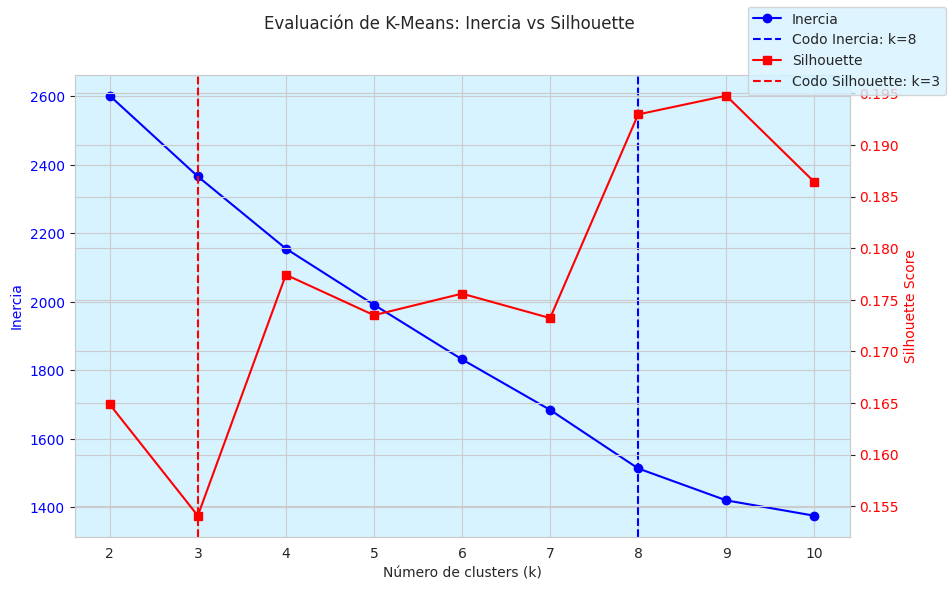

{'inercia': [2601.719964030671,
  2365.9811361185452,
  2155.286418902703,
  1991.5285164310285,
  1831.9808730770371,
  1684.5304634895003,
  1513.6538171823279,
  1420.441973951081,
  1375.5927174423625],
 'silhouette': [np.float64(0.16486461779300848),
  np.float64(0.15407662544565454),
  np.float64(0.17742952054340075),
  np.float64(0.17351175988936712),
  np.float64(0.17560137470278822),
  np.float64(0.17323306260013543),
  np.float64(0.19297218567870372),
  np.float64(0.19478290547200597),
  np.float64(0.18642443541740097)],
 'k_optimo_inercia': np.int64(8),
 'k_optimo_silhouette': np.int64(3)}

In [ ]:
# Clustering con las primeras 11 componentes
CP_reducido = CP.iloc[:, :11]

# Numero de clusters
kmeans_n_clusters(CP_reducido)

Para determinar el número óptimo de clusters en el modelo K-Means, se aplicaron dos criterios complementarios: el método del codo sobre la inercia y el análisis del coeficiente de silhouette. La inercia representa la suma de distancias internas dentro de cada cluster, mientras que el silhouette mide la coherencia de cada punto respecto a su propio grupo y a los grupos vecinos.

El gráfico muestra que la inercia disminuye progresivamente a medida que se incrementa el número de clusters, con un cambio de pendiente más marcado en k = 8, lo que sugiere un punto de inflexión según el método del codo. Sin embargo, el coeficiente de silhouette alcanza su valor máximo en k = 3, indicando que con tres clusters se logra una mejor separación y cohesión entre grupos.

Esta discrepancia entre ambos criterios es común en análisis no supervisados. En este caso, se optó por k = 3 como número óptimo de clusters, priorizando la calidad de agrupamiento sobre la reducción de inercia. Esta elección permite una segmentación más coherente de los datos, útil para explorar perfiles de pacientes con características similares, independientemente de la variable objetivo.

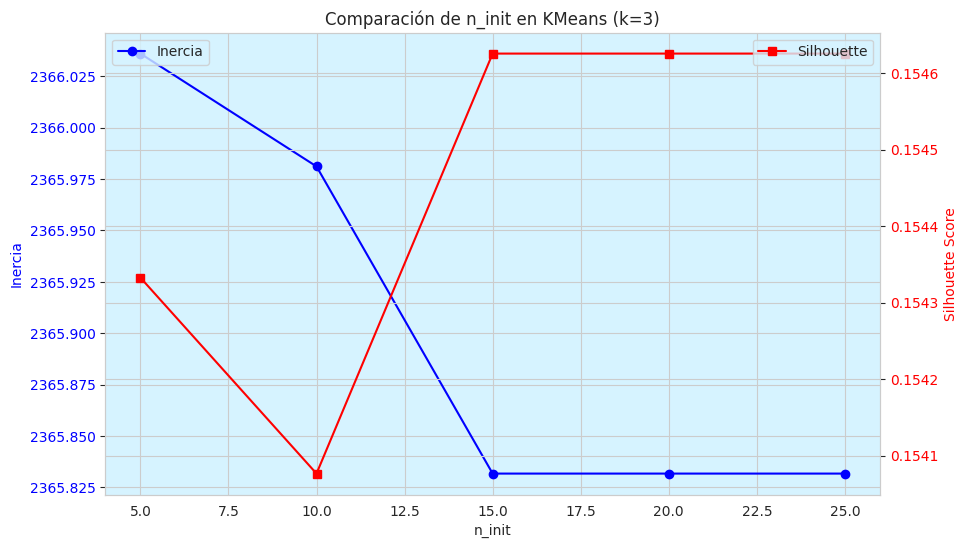

{'valores_n_init': [5, 10, 15, 20, 25],
 'inercia': [2366.036048392107,
  2365.9811361185452,
  2365.8316802779855,
  2365.8316802779855,
  2365.8316802779855],
 'silhouette_scores': [np.float64(0.15433281409870364),
  np.float64(0.15407662544565454),
  np.float64(0.1546256514518124),
  np.float64(0.1546256514518124),
  np.float64(0.1546256514518124)]}

In [ ]:
kmeans_n_init(df_scaled= CP_reducido, n_clusters= 3)

Los resultados muestran que la inercia disminuye progresivamente al aumentar n_init, estabilizándose a partir de n_init = 15, lo que indica una mejor compactación interna de los clusters. Por otro lado, el coeficiente de silhouette presenta una caída inicial en n_init = 10, pero luego se recupera y se estabiliza en valores más altos desde n_init = 15, reflejando una mejor separación entre grupos.

Estos hallazgos sugieren que un valor de n_init ≥ 15 mejora la estabilidad y calidad del agrupamiento, reduciendo el riesgo de converger a soluciones subóptimas por inicializaciones desfavorables. En consecuencia, se seleccionó n_init = 25 como configuración final para el modelo K-Means, garantizando robustez en la segmentación de pacientes.

In [ ]:
# Modelo final con parámetros óptimos
modelo_KMEANS = KMeans(
    n_clusters= 3,       # número de clusters
    init='k-means++',    # inicialización robusta
    n_init=15,           # repite con diferentes centroides
    max_iter=300,        # máximo de iteraciones
    random_state=42,     # reproducibilidad
    algorithm='lloyd'    # algoritmo estándar, util para dataset pequeños o medianos
    )

# Ajustar el modelo
modelo_KMEANS.fit(CP_reducido)

# Etiquetas de cluster
df_clusters = CP_reducido.copy()
df_clusters['clusters'] = modelo_KMEANS.labels_

df_clusters.clusters.value_counts()

,count
clusters,
1,92
0,70
2,50


### STEP AIC

In [ ]:
######################################################################################
#################### Criterio de Información de Akaike ###############################
######################################################################################
# Función para realizar step AIC
def step_aic(X, y):
    """
    Realiza step AIC para seleccionar el mejor conjunto de variables.
    """
    remaining = set(X.columns)#CONJUNTO de variables candidatas que aún  no han sido selecionadas
    selected = []#lista de las variables ya seleccionadas para el modelo
    best_score = np.inf#vairbale para almacernar el menor valor de AIC encontrado hasta ahora. Se inicia con infinito (np.onf) para
    #asegurar que cualquier AIC sea menor que el inicial

    while remaining:#mientras haya variables candidatas disponibles, el bucle continua
        scores_with_candidates = []#almacenar el AIC y la variable candidata en una lista
        for candidate in remaining:##itera sobre cada variable candidata
            formula = " + ".join(selected + [candidate])##crea una formula con las variables seleccionadas mas la candidata actua
    ###############construye un modelo de regresion logistica con las variables seleccionadas y la candidata
            model = sm.Logit(y, sm.add_constant(X[selected + [candidate]]))
    #######################################################################################
            result = model.fit(disp=0)#ajusta el modelo sin mostrar el mensaje de salidad disp=0
            score = result.aic#calcula el aic del modelo ajustado

            scores_with_candidates.append((score, candidate))#almacenha el aic y la variable candidata

        # Seleccionar la variable con el menor AIC

        scores_with_candidates.sort(key=lambda x: x[0])#ordena las variables candidatas por su AIC por el primer valor de la tupla
        best_new_score, best_candidate = scores_with_candidates[0]#extrae el menor aic y la variable candidata

        if best_new_score < best_score:#actualizar la variable seleccionada
            remaining.remove(best_candidate)#elimina la variable seleccionada del conjunto de candidatas
            selected.append(best_candidate)#agrega la variable del conjunto de variables selccionadas
            best_score = best_new_score#actualizar el mejor AIC
        else:
            break#si el aic no mejora el bucle termina

    return selected#retorna la lista de variables seleccionadas que minimizan el AIC


In [ ]:
# Agrega la constante (intercepto)
X_train_const = sm.add_constant(Xc_tr)

# Aplicar step AIC
selected_features = step_aic(Xc_tr, yc_tr)
print("\nVariables seleccionadas por Step AIC:")
print(selected_features)

# Reducir el dataset a las variables seleccionadas
X_train_AIC = Xc_tr[selected_features]
X_test_AIC = Xc_te[selected_features]



Variables seleccionadas por Step AIC:
['vasos_coloreados', 'tipo_dolor_pecho_dolor no anginoso', 'talasemia_defecto reversible', 'pendiente_ST_plano', 'depresion_ST', 'electrocardiograma_reposo_Hipertrofia ventricular izquierda', 'tipo_dolor_pecho_angina típica', 'presion_arterial_reposo', 'frecuencia_cardiaca_max', 'colesterol', 'sexo']


### Boruta

#### Grid Search

In [ ]:
# Definir el espacio de búsqueda
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Modelo base
rf_base = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)

# Grid Search
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(Xc_tr, yc_tr)

# Mejor modelo
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, 

In [ ]:
best_rf

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=3,
                       min_samples_leaf=4, n_estimators=300, n_jobs=-1,
                       random_state=42)

#### Aplicar Boruta

In [ ]:
# Inicializar Boruta
boruta_selector = BorutaPy(estimator=best_rf, n_estimators='auto', verbose=2, random_state=42)

# Ajustar al dataset
boruta_selector.fit(Xc_tr.values, yc_tr.values)


# Variables aceptadas por Boruta
selected_features = Xc_tr.columns[boruta_selector.support_].tolist()
print("✅ Variables seleccionadas por Boruta:")
print(selected_features)

# Variables rechazadas
rejected_features = Xc_tr.columns[~boruta_selector.support_].tolist()
print("\n❌ Variables descartadas por Boruta:")
print(rejected_features)

# Convertimos a DataFrame
X_train_Boruta = Xc_tr[selected_features]
X_test_Boruta = Xc_te[selected_features]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	3
Rejected: 	6
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	3
Rejected: 	6
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	3
Rejected: 	6
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	3
Rejected: 	6
Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	3
Rejected: 	6
Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	3
Rejected: 	6
Iteration: 	14 / 100
Confirmed: 	9
Tentative: 	3
Rejected: 	6
Iteration: 	15 / 100
Confirmed: 	9
Tentative: 	3
Rejected: 	6
Iteration: 	16 / 100
Confirmed: 	9
Tentative: 	3
Rejected: 	6
Iteration:

### Modelos

#### Regresion Logistica

In [ ]:
def modelar_GS_reg_log(X_train, txt = "BASE"):
  # Modelo base
  logreg = LogisticRegression(class_weight='balanced', random_state=42)

  # Definir el espacio de búsqueda
  param_grid = {
      'C': [0.01, 0.1, 1, 10],
      'penalty': ['l1', 'l2'],
      'solver': ['liblinear'],  # compatible con l1 y l2
      'max_iter': [100, 200]
  }

  # Grid Search
  grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)
  grid_search.fit(X_train, yc_tr)

  # Mejor modelo
  print(f"\n🎯 MODELO {txt} - REGRESIÓN LOGÍSTICA BINARIA:")
  log_reg = grid_search.best_estimator_
  print("\n✅ Mejor modelo encontrado:")
  print(log_reg)

  return log_reg

In [ ]:
def metricas_reg_log(log_reg, Xc_te_sc, txt = "BASE"):
  # Predicciones
  yc_pred = log_reg.predict(Xc_te_sc)
  yc_proba = log_reg.predict_proba(Xc_te_sc)[:,1]

  # Métricas
  acc = accuracy_score(yc_te, yc_pred)
  prec = precision_score(yc_te, yc_pred)
  rec = recall_score(yc_te, yc_pred)
  f1 = f1_score(yc_te, yc_pred)
  auc = roc_auc_score(yc_te, yc_proba)

  print(f"=== MÉTRICAS FINALES  DE {txt} ===")
  print(f"Accuracy : {acc:.3f}") # proporcion de pertenencia o "Prediccione correctas"
  print(f"Precision: {prec:.3f}")
  print(f"Recall   : {rec:.3f}")
  print(f"F1-Score : {f1:.3f}")
  print(f"AUC-ROC  : {auc:.3f}") # Capacidad para diferenciar

  result = pd.DataFrame({
    "Accuracy": [acc],
    "Precision": [prec],
    "Recall": [rec],
    "F1-Score": [f1],
    "AUC-ROC": [auc]
    })

  return yc_pred, yc_proba, result

In [ ]:
def matriz_confusion(y_pred, modelo="Modelo", txt="Base"):
    """
    Genera y visualiza la matriz de confusión para cualquier clasificador.

    Parámetros
    ----------
    y_pred : array-like
        Predicciones del modelo.
    modelo : str, opcional
        Nombre del modelo (ej. 'Regresión Logística', 'KNN').
    txt : str, opcional
        Texto adicional para identificar la versión del modelo.
    """
    # Matriz de confusión
    cm = confusion_matrix(yc_te, y_pred)

    # Visualización
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['Sano (0)', 'Enfermo (1)'])
    disp.plot(cmap='Blues', colorbar=False)

    # Título y estilo
    plt.title(f'Matriz de Confusión - Hospital Regional "Vida Salud"\n{modelo} {txt}')
    plt.xlabel('Predicción del modelo')
    plt.ylabel('Diagnóstico real')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

##### Modelo Base

In [ ]:
log_reg_Base = modelar_GS_reg_log(Xc_tr, "BASE")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=200, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=200, penalty=l1, solv

In [ ]:
yc_pred_Base, yc_proba_Base, result_Base = metricas_reg_log(log_reg_Base, Xc_te, "BASE")

=== MÉTRICAS FINALES  DE BASE ===
Accuracy : 0.857
Precision: 0.939
Recall   : 0.738
F1-Score : 0.827
AUC-ROC  : 0.919


<Figure size 600x500 with 0 Axes>

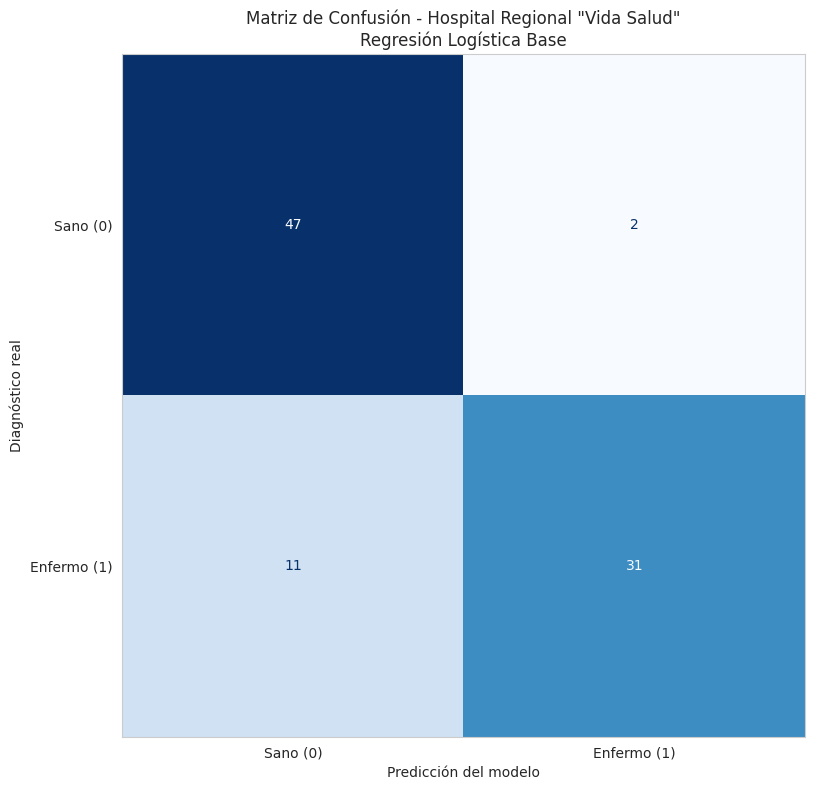

In [ ]:
matriz_confusion(yc_pred_Base, modelo= "Regresión Logística", txt = "Base")

##### Modelo AIC

In [ ]:
log_reg_AIC = modelar_GS_reg_log(X_train_AIC, "AIC")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=200, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=200, penalty=l1, solv

In [ ]:
yc_pred_AIC, yc_proba_AIC, result_AIC = metricas_reg_log(log_reg_AIC, X_test_AIC, "AIC")

=== MÉTRICAS FINALES  DE AIC ===
Accuracy : 0.857
Precision: 0.914
Recall   : 0.762
F1-Score : 0.831
AUC-ROC  : 0.924


<Figure size 600x500 with 0 Axes>

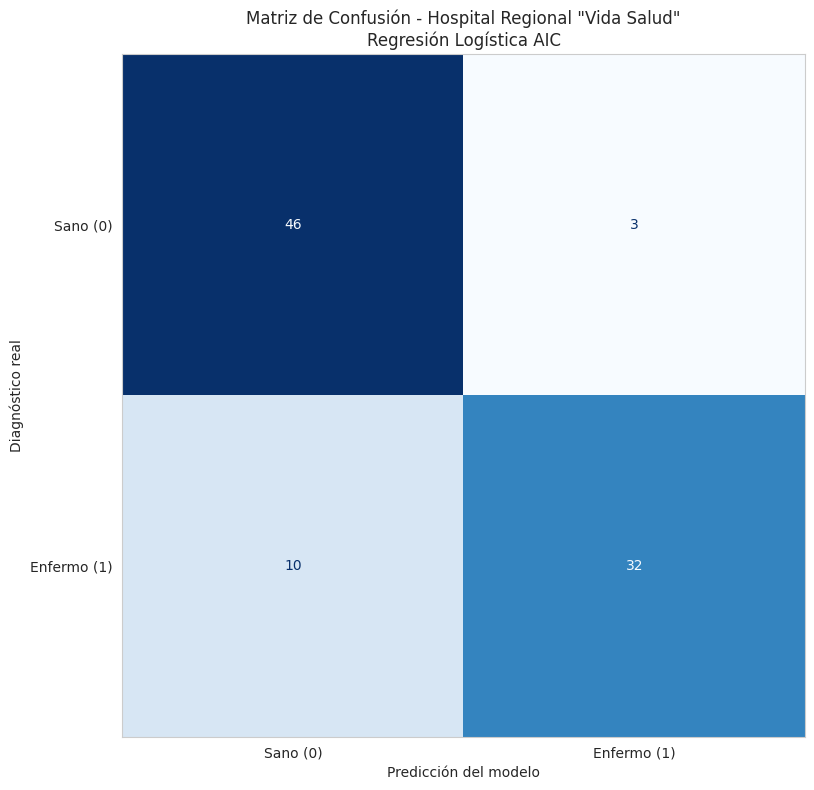

In [ ]:
matriz_confusion(yc_pred_AIC, modelo= "Regresión Logística", txt = "AIC")

##### Modelo Boruta

In [ ]:
log_reg_Boruta = modelar_GS_reg_log(X_train_Boruta, "Boruta")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=200, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=200, penalty=l1, solv

In [ ]:
yc_pred_Boruta, yc_proba_Boruta, result_Boruta = metricas_reg_log(log_reg_Boruta, X_test_Boruta, "Boruta")

=== MÉTRICAS FINALES  DE Boruta ===
Accuracy : 0.857
Precision: 0.939
Recall   : 0.738
F1-Score : 0.827
AUC-ROC  : 0.923


<Figure size 600x500 with 0 Axes>

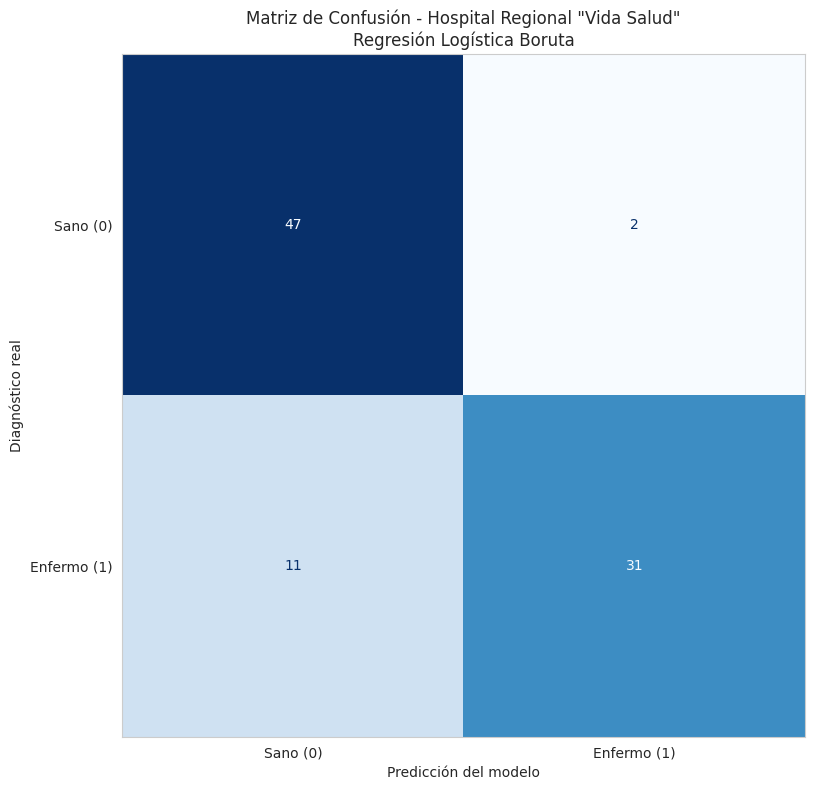

In [ ]:
matriz_confusion(yc_pred_Boruta, modelo= "Regresión Logística", txt = "Boruta")

#### KNN

Se utilizó la métrica Minkowski con p=2, equivalente a la distancia Euclídea, por ser la más común en espacios vectoriales normalizados y porque refleja la proximidad geométrica entre observaciones.

In [ ]:
def train_best_knn(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    k_range: range = range(1, 21),
    cv: int = 5,
    metric: str = "minkowski",
    p: int = 2 ) -> Tuple[KNeighborsClassifier, int, List[float]]:
    """
    Entrena un modelo KNN seleccionando el mejor número de vecinos mediante validación cruzada.

    Parámetros
    ----------
    X_train : pd.DataFrame
        Conjunto de entrenamiento (variables predictoras).
    y_train : pd.Series
        Variable dependiente binaria (0/1).
    k_range : range, opcional
        Rango de valores de k a probar (default: 1 a 20).
    cv : int, opcional
        Número de pliegues para validación cruzada (default: 5).
    metric : str, opcional
        Métrica de distancia (default: "minkowski").
    p : int, opcional
        Parámetro de Minkowski (p=2 → Euclídea, p=1 → Manhattan).

    Retorna
    -------
    model : KNeighborsClassifier
        Modelo KNN entrenado con el mejor k.
    best_k : int
        Número óptimo de vecinos seleccionado.
    cv_scores : List[float]
        Lista con los puntajes promedio de validación cruzada para cada k.
    """
    cv_scores = []

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric, p=p)
        scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring="accuracy")
        cv_scores.append(scores.mean())
        print(f"Precisión por {k}k:", scores)

    best_k = k_range[np.argmax(cv_scores)]
    model = KNeighborsClassifier(n_neighbors=best_k, metric=metric, p=p)
    model.fit(X_train, y_train)

    print("\nMejor modelo KNN:")
    print(model)

    return model

In [ ]:
def metricas_knn(knn_model, X_test, y_test, txt="KNN"):
    """
    Calcula métricas de desempeño para un modelo KNN.

    Parámetros
    ----------
    knn_model : KNeighborsClassifier
        Modelo KNN ya entrenado.
    X_test : pd.DataFrame
        Conjunto de prueba (predictoras).
    y_test : pd.Series
        Variable dependiente binaria (0/1).
    txt : str, opcional
        Texto descriptivo para identificar el modelo en la salida.

    Retorna
    -------
    y_pred : np.ndarray
        Predicciones de clase.
    y_proba : np.ndarray
        Probabilidades de pertenencia a la clase positiva.
    result : pd.DataFrame
        DataFrame con métricas (Accuracy, Precision, Recall, F1, AUC).
    """
    # Predicciones
    y_pred = knn_model.predict(X_test)
    y_proba = knn_model.predict_proba(X_test)[:, 1]

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"=== MÉTRICAS FINALES DE {txt} ===")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-Score : {f1:.3f}")
    print(f"AUC-ROC  : {auc:.3f}")

    result = pd.DataFrame({
        "Accuracy": [acc],
        "Precision": [prec],
        "Recall": [rec],
        "F1-Score": [f1],
        "AUC-ROC": [auc]
    })

    return y_pred, y_proba, result

##### Modelo Base

In [ ]:
knn_Base = train_best_knn(Xc_tr, yc_tr)

Precisión por 1k: [0.8372093  0.65116279 0.83333333 0.76190476 0.66666667]
Precisión por 2k: [0.72093023 0.65116279 0.80952381 0.71428571 0.73809524]
Precisión por 3k: [0.81395349 0.55813953 0.78571429 0.76190476 0.80952381]
Precisión por 4k: [0.74418605 0.60465116 0.83333333 0.69047619 0.83333333]
Precisión por 5k: [0.86046512 0.60465116 0.80952381 0.76190476 0.76190476]
Precisión por 6k: [0.81395349 0.6744186  0.85714286 0.73809524 0.73809524]
Precisión por 7k: [0.8372093  0.69767442 0.85714286 0.73809524 0.73809524]
Precisión por 8k: [0.81395349 0.76744186 0.83333333 0.76190476 0.71428571]
Precisión por 9k: [0.8372093  0.74418605 0.88095238 0.76190476 0.69047619]
Precisión por 10k: [0.81395349 0.74418605 0.85714286 0.73809524 0.71428571]
Precisión por 11k: [0.8372093  0.76744186 0.83333333 0.78571429 0.73809524]
Precisión por 12k: [0.79069767 0.76744186 0.83333333 0.78571429 0.73809524]
Precisión por 13k: [0.8372093  0.76744186 0.80952381 0.83333333 0.73809524]
Precisión por 14k: [0

In [ ]:
y_pred_knn_Base, y_proba_knn_Base, result_knn_Base = metricas_knn(knn_Base, Xc_te, yc_te, txt="KNN en Base")

=== MÉTRICAS FINALES DE KNN en Base ===
Accuracy : 0.835
Precision: 0.865
Recall   : 0.762
F1-Score : 0.810
AUC-ROC  : 0.919


<Figure size 600x500 with 0 Axes>

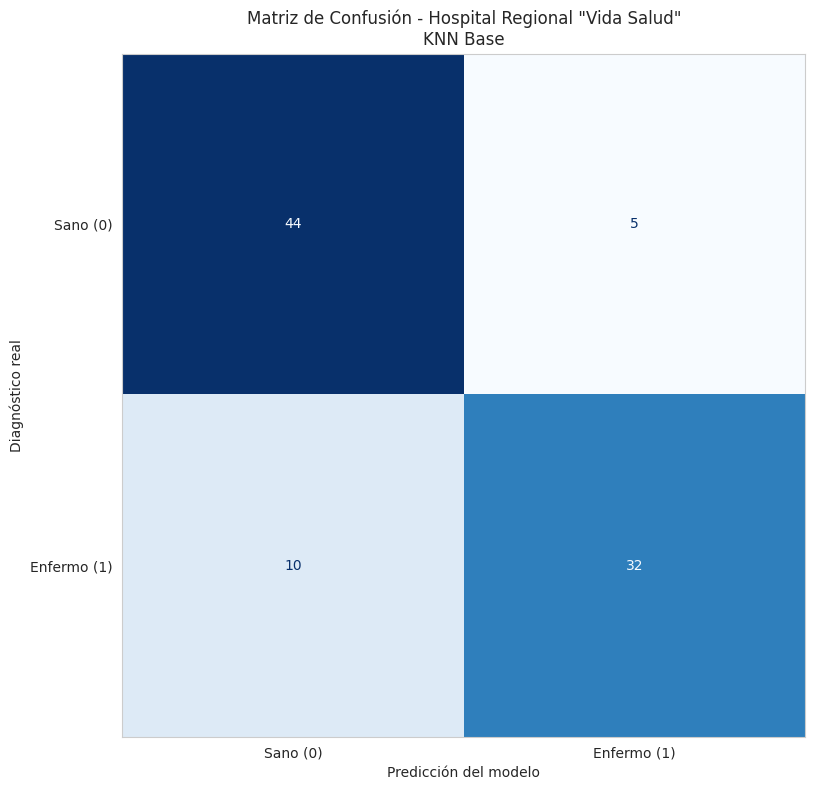

In [ ]:
matriz_confusion(y_pred_knn_Base, modelo= "KNN", txt = "Base")

##### Modelo AIC

In [ ]:
knn_AIC = train_best_knn(X_train_AIC, yc_tr)

Precisión por 1k: [0.79069767 0.69767442 0.83333333 0.69047619 0.73809524]
Precisión por 2k: [0.74418605 0.81395349 0.83333333 0.69047619 0.71428571]
Precisión por 3k: [0.76744186 0.79069767 0.80952381 0.73809524 0.78571429]
Precisión por 4k: [0.74418605 0.8372093  0.80952381 0.66666667 0.78571429]
Precisión por 5k: [0.79069767 0.74418605 0.78571429 0.80952381 0.80952381]
Precisión por 6k: [0.74418605 0.69767442 0.80952381 0.78571429 0.83333333]
Precisión por 7k: [0.79069767 0.74418605 0.78571429 0.80952381 0.83333333]
Precisión por 8k: [0.81395349 0.79069767 0.80952381 0.83333333 0.83333333]
Precisión por 9k: [0.8372093  0.79069767 0.83333333 0.83333333 0.83333333]
Precisión por 10k: [0.8372093  0.79069767 0.83333333 0.83333333 0.83333333]
Precisión por 11k: [0.81395349 0.79069767 0.80952381 0.80952381 0.85714286]
Precisión por 12k: [0.79069767 0.81395349 0.83333333 0.83333333 0.85714286]
Precisión por 13k: [0.79069767 0.76744186 0.85714286 0.83333333 0.88095238]
Precisión por 14k: [0

In [ ]:
y_pred_knn_AIC, y_proba_knn_AIC, result_knn_AIC = metricas_knn(knn_AIC, X_test_AIC, yc_te, txt="KNN en AIC")

=== MÉTRICAS FINALES DE KNN en AIC ===
Accuracy : 0.846
Precision: 0.938
Recall   : 0.714
F1-Score : 0.811
AUC-ROC  : 0.922


<Figure size 600x500 with 0 Axes>

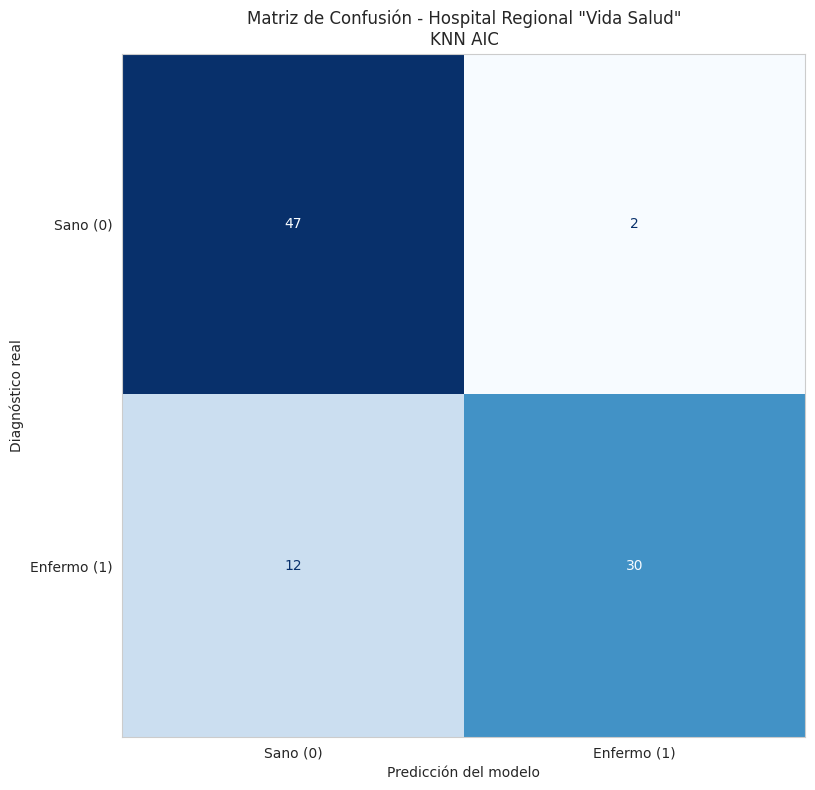

In [ ]:
matriz_confusion(y_pred_knn_AIC, modelo= "KNN", txt = "AIC")

##### Modelo Boruta

In [ ]:
knn_Boruta = train_best_knn(X_train_Boruta, yc_tr)

Precisión por 1k: [0.81395349 0.69767442 0.83333333 0.66666667 0.76190476]
Precisión por 2k: [0.76744186 0.74418605 0.88095238 0.61904762 0.73809524]
Precisión por 3k: [0.8372093  0.72093023 0.85714286 0.73809524 0.85714286]
Precisión por 4k: [0.8372093  0.76744186 0.88095238 0.69047619 0.83333333]
Precisión por 5k: [0.86046512 0.79069767 0.88095238 0.76190476 0.83333333]
Precisión por 6k: [0.8372093  0.81395349 0.83333333 0.80952381 0.80952381]
Precisión por 7k: [0.86046512 0.8372093  0.85714286 0.80952381 0.85714286]
Precisión por 8k: [0.86046512 0.79069767 0.85714286 0.78571429 0.83333333]
Precisión por 9k: [0.88372093 0.81395349 0.85714286 0.80952381 0.83333333]
Precisión por 10k: [0.88372093 0.76744186 0.88095238 0.76190476 0.80952381]
Precisión por 11k: [0.88372093 0.8372093  0.88095238 0.78571429 0.83333333]
Precisión por 12k: [0.88372093 0.79069767 0.88095238 0.76190476 0.83333333]
Precisión por 13k: [0.88372093 0.8372093  0.85714286 0.78571429 0.83333333]
Precisión por 14k: [0

In [ ]:
y_pred_knn_Boruta, y_proba_knn_Boruta, result_knn_Boruta = metricas_knn(knn_Boruta, X_test_Boruta, yc_te, txt="KNN en Boruta")

=== MÉTRICAS FINALES DE KNN en Boruta ===
Accuracy : 0.824
Precision: 0.861
Recall   : 0.738
F1-Score : 0.795
AUC-ROC  : 0.904


<Figure size 600x500 with 0 Axes>

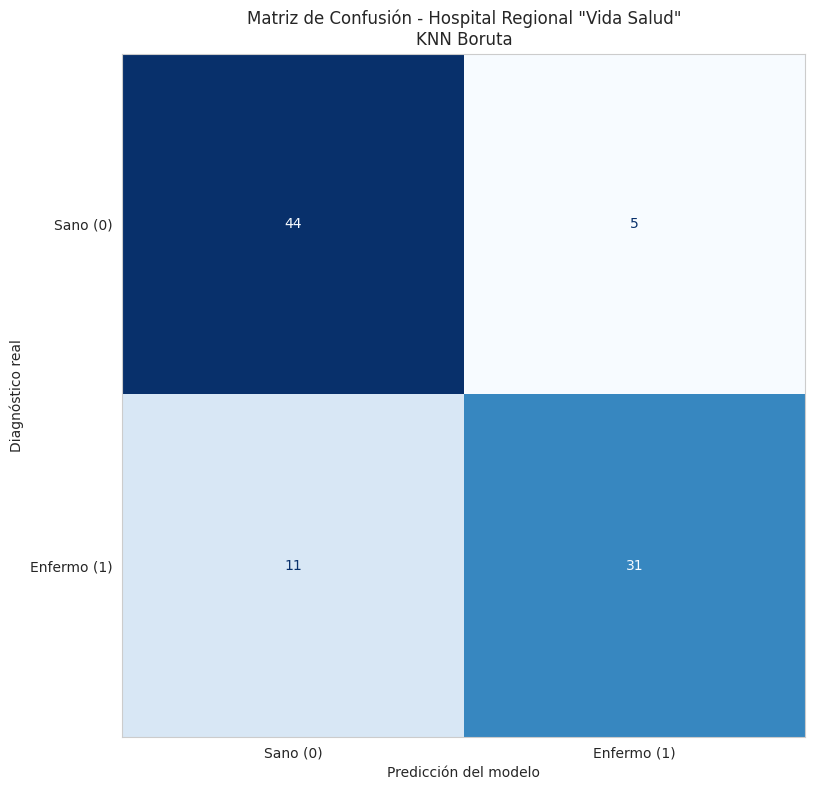

In [ ]:
matriz_confusion(y_pred_knn_Boruta, modelo= "KNN", txt = "Boruta")

#### MLP (Multi‑Layer Perceptron)

In [ ]:
def train_best_mlp(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    param_grid: Dict = None,
    cv: int = 5,
    scoring: str = "accuracy",
    max_iter: int = 500,
    random_state: int = 42 ) -> Tuple[MLPClassifier, Dict, float]:
    """
    Entrena un modelo MLP seleccionando la mejor configuración de hiperparámetros mediante GridSearchCV.

    Parámetros
    ----------
    X_train : pd.DataFrame
        Conjunto de entrenamiento (variables predictoras).
    y_train : pd.Series
        Variable dependiente binaria (0/1).
    param_grid : dict, opcional
        Espacio de búsqueda de hiperparámetros. Si no se especifica, se usa un grid por defecto.
    cv : int, opcional
        Número de pliegues para validación cruzada (default: 5).
    scoring : str, opcional
        Métrica de evaluación (default: "accuracy").
    max_iter : int, opcional
        Número máximo de iteraciones de entrenamiento (default: 500).
    random_state : int, opcional
        Semilla para reproducibilidad (default: 42).

    Retorna
    -------
    model : MLPClassifier
        Modelo MLP entrenado con los mejores hiperparámetros.
    best_params : dict
        Diccionario con los parámetros óptimos encontrados.
    best_score : float
        Score promedio de validación cruzada con los mejores parámetros.
    """

    # Grid por defecto si no se pasa uno
    if param_grid is None:
        param_grid = {
            'hidden_layer_sizes': [(50,), (100,), (50, 25)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'sgd'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01]
        }

    mlp = MLPClassifier(max_iter=max_iter, random_state=random_state)

    grid_search = GridSearchCV(mlp, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("\nMejor modelo MLP:")
    print(best_model)
    print("Mejores parámetros:", best_params)
    print("Mejor score de validación:", best_score)

    return best_model

In [ ]:
def metricas_mlp(mlp_model, X_test, y_test, txt="MLP"):
    """
    Calcula métricas de desempeño para un modelo MLPClassifier.

    Parámetros
    ----------
    mlp_model : MLPClassifier
        Modelo MLP ya entrenado.
    X_test : pd.DataFrame
        Conjunto de prueba (predictoras).
    y_test : pd.Series
        Variable dependiente binaria (0/1).
    txt : str, opcional
        Texto descriptivo para identificar el modelo en la salida.

    Retorna
    -------
    y_pred : np.ndarray
        Predicciones de clase.
    y_proba : np.ndarray
        Probabilidades de pertenencia a la clase positiva.
    result : pd.DataFrame
        DataFrame con métricas (Accuracy, Precision, Recall, F1, AUC).
    """
    # Predicciones
    y_pred = mlp_model.predict(X_test)
    y_proba = mlp_model.predict_proba(X_test)[:, 1]

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"=== MÉTRICAS FINALES DE {txt} ===")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-Score : {f1:.3f}")
    print(f"AUC-ROC  : {auc:.3f}")

    result = pd.DataFrame({
        "Accuracy": [acc],
        "Precision": [prec],
        "Recall": [rec],
        "F1-Score": [f1],
        "AUC-ROC": [auc]
    })

    return y_pred, y_proba, result

##### Modelo Base

In [ ]:
mlp_Base = train_best_mlp(Xc_tr, yc_tr)


Mejor modelo MLP:
MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42,
              solver='sgd')
Mejores parámetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'sgd'}
Mejor score de validación: 0.8117386489479512


In [ ]:
y_pred_mlp_Base, y_proba_mlp_Base, result_mlp_Base = metricas_mlp(mlp_Base, Xc_te, yc_te, txt="MLP en Base")

=== MÉTRICAS FINALES DE MLP en Base ===
Accuracy : 0.835
Precision: 0.909
Recall   : 0.714
F1-Score : 0.800
AUC-ROC  : 0.922


<Figure size 600x500 with 0 Axes>

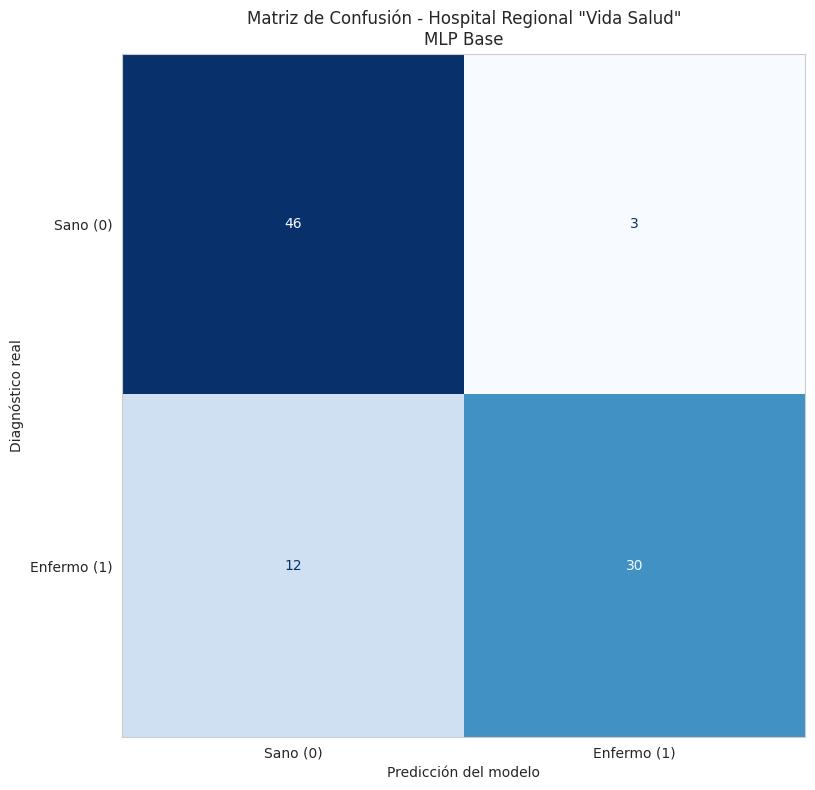

In [ ]:
matriz_confusion(y_pred_mlp_Base, modelo= "MLP", txt = "Base")

##### Modelo AIC

In [ ]:
mlp_AIC = train_best_mlp(X_train_AIC, yc_tr)


Mejor modelo MLP:
MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42,
              solver='sgd')
Mejores parámetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'sgd'}
Mejor score de validación: 0.8442967884828351


In [ ]:
y_pred_mlp_AIC, y_proba_mlp_AIC, result_mlp_AIC = metricas_mlp(mlp_AIC, X_test_AIC, yc_te, txt="MLP en AIC")

=== MÉTRICAS FINALES DE MLP en AIC ===
Accuracy : 0.857
Precision: 0.939
Recall   : 0.738
F1-Score : 0.827
AUC-ROC  : 0.914


<Figure size 600x500 with 0 Axes>

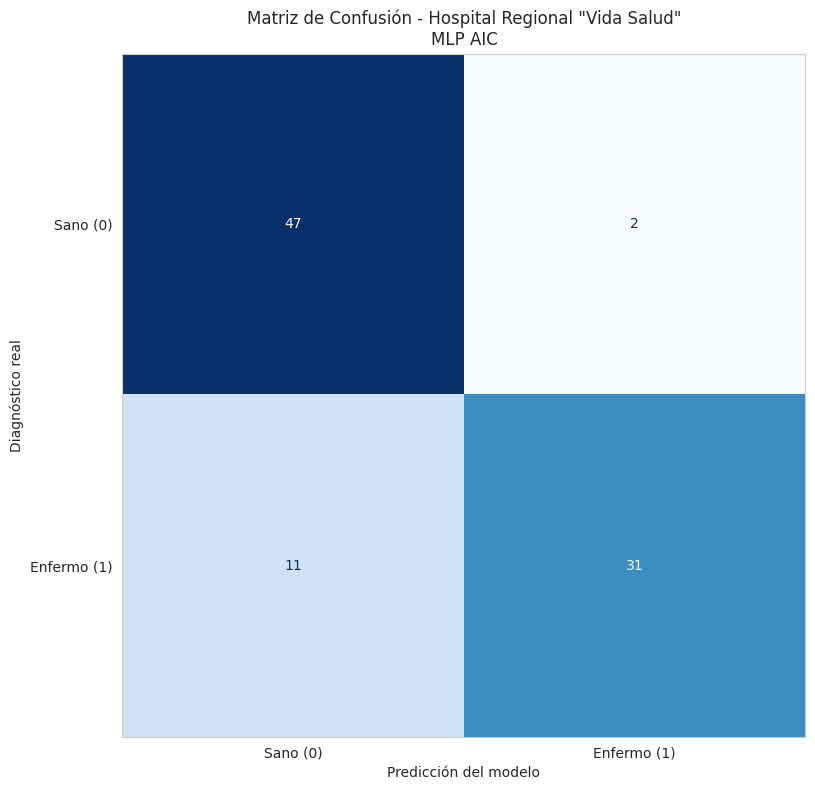

In [ ]:
matriz_confusion(y_pred_mlp_AIC, modelo= "MLP", txt = "AIC")

##### Modelo Boruta

In [ ]:
mlp_Boruta = train_best_mlp(X_train_Boruta, yc_tr)


Mejor modelo MLP:
MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=500,
              random_state=42, solver='sgd')
Mejores parámetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'solver': 'sgd'}
Mejor score de validación: 0.8493909191583612


In [ ]:
y_pred_mlp_Boruta, y_proba_mlp_Boruta, result_mlp_Boruta = metricas_mlp(mlp_Boruta, X_test_Boruta, yc_te, txt="MLP en Boruta")

=== MÉTRICAS FINALES DE MLP en Boruta ===
Accuracy : 0.813
Precision: 0.821
Recall   : 0.762
F1-Score : 0.790
AUC-ROC  : 0.875


<Figure size 600x500 with 0 Axes>

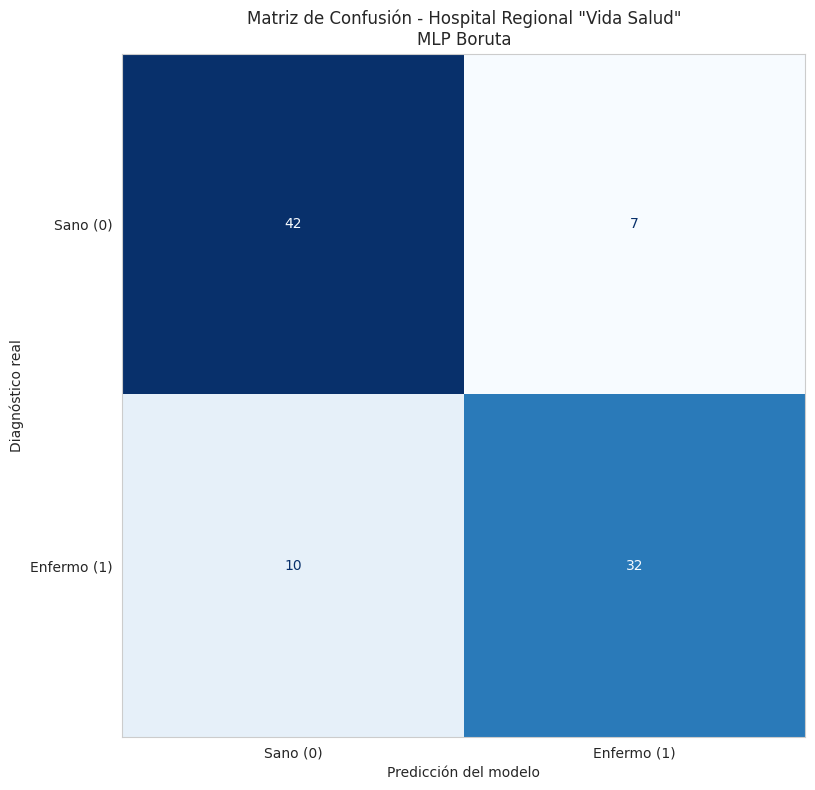

In [ ]:
matriz_confusion(y_pred_mlp_Boruta, modelo= "MLP", txt = "Boruta")

## Assess (Evaluación)

### Evaluar Modelos

In [ ]:
# Lista de resultados con sus etiquetas
resultados = [
    ("LogReg - Base",   result_Base),
    ("LogReg - AIC",    result_AIC),
    ("LogReg - Boruta", result_Boruta),
    ("KNN - Base",      result_knn_Base),
    ("KNN - AIC",       result_knn_AIC),
    ("KNN - Boruta",    result_knn_Boruta),
    ("MLP - Base",      result_mlp_Base),
    ("MLP - AIC",       result_mlp_AIC),
    ("MLP - Boruta",    result_mlp_Boruta) ]

# Agregar columna Modelo y concatenar
df_list = []
for nombre, df in resultados:
    df["Modelo"] = nombre
    df_list.append(df)

# Unir todos los resultados
result = pd.concat(df_list, ignore_index=True)
result = result.set_index("Modelo")
result.index.name = None

# Ordenar por AUC-ROC
result = result.sort_values(by="AUC-ROC", ascending=False)
print(result)

                 Accuracy  Precision    Recall  F1-Score   AUC-ROC
LogReg - AIC     0.857143   0.914286  0.761905  0.831169  0.923712
LogReg - Boruta  0.857143   0.939394  0.738095  0.826667  0.922983
MLP - Base       0.835165   0.909091  0.714286  0.800000  0.922255
KNN - AIC        0.846154   0.937500  0.714286  0.810811  0.922012
KNN - Base       0.835165   0.864865  0.761905  0.810127  0.919339
LogReg - Base    0.857143   0.939394  0.738095  0.826667  0.918853
MLP - AIC        0.857143   0.939394  0.738095  0.826667  0.913508
KNN - Boruta     0.824176   0.861111  0.738095  0.794872  0.904276
MLP - Boruta     0.813187   0.820513  0.761905  0.790123  0.874636


#### Gráfico comparativo de métricas

<Figure size 1200x800 with 0 Axes>

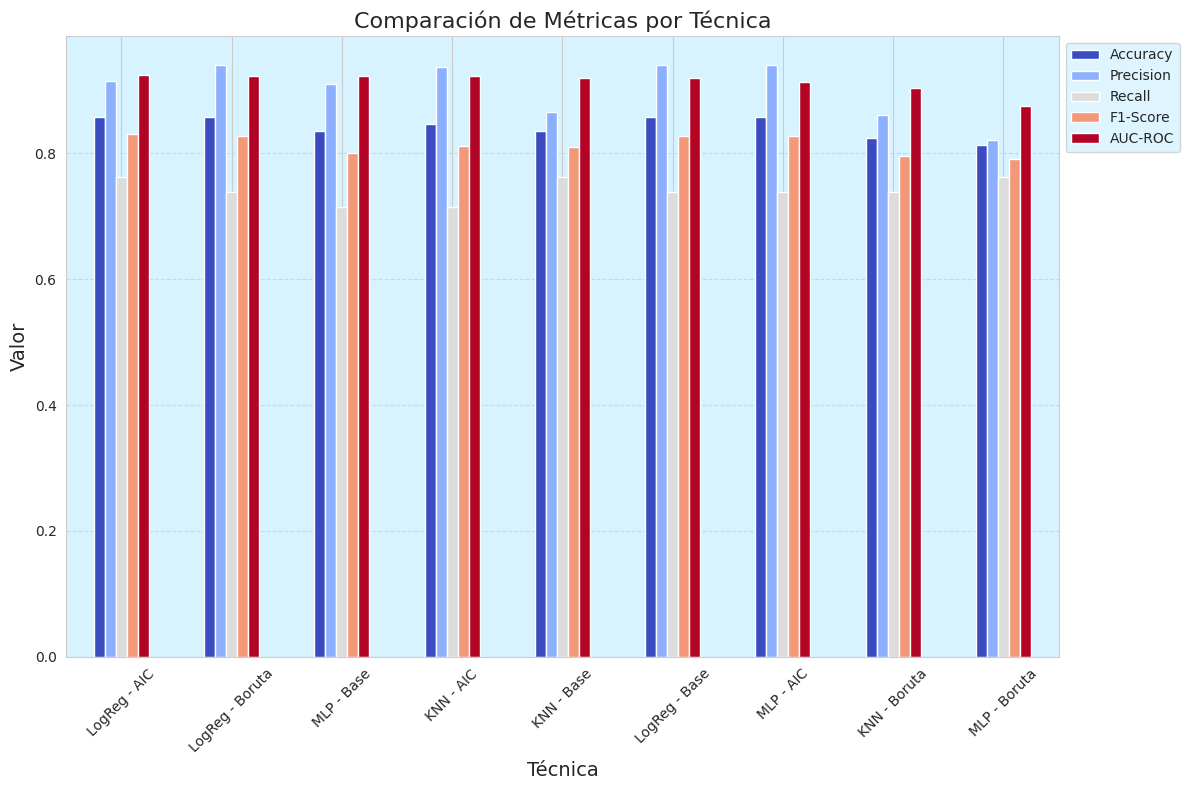

In [ ]:
# Gráfico comparativo de métricas
plt.figure(figsize=(12, 8))
result.plot(kind='bar', colormap='coolwarm', figsize=(12, 8))
plt.title("Comparación de Métricas por Técnica", fontsize=16)
plt.xlabel("Técnica", fontsize=14)
plt.ylabel("Valor", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

#### curva ROC

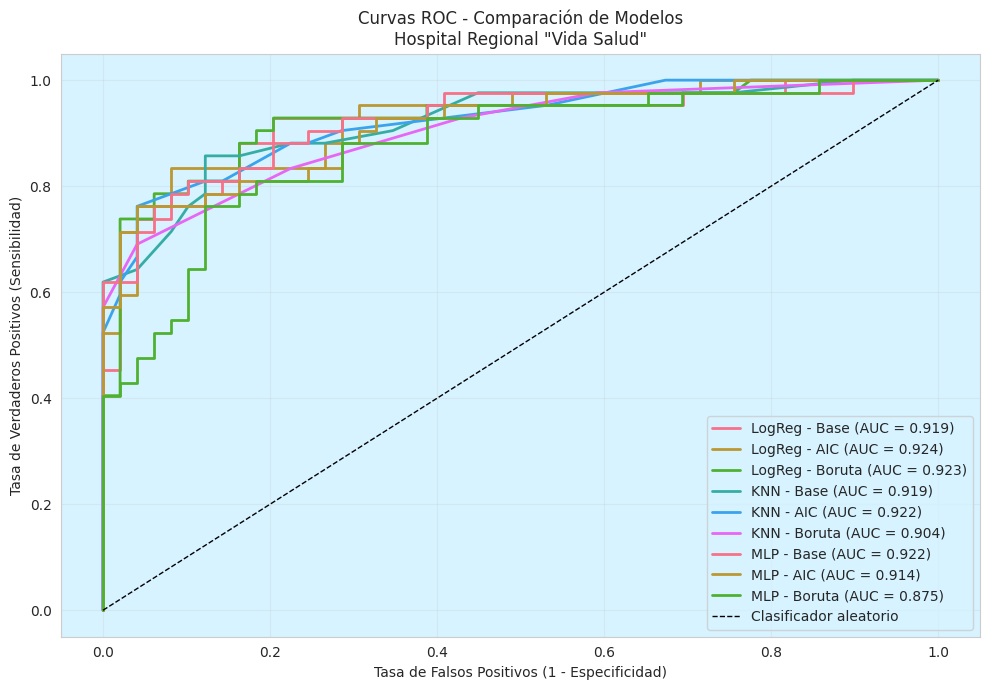

In [ ]:
# Diccionario con las probabilidades de cada modelo
probas_dict = {
    "LogReg - Base": yc_proba_Base,
    "LogReg - AIC": yc_proba_AIC,
    "LogReg - Boruta": yc_proba_Boruta,
    "KNN - Base": y_proba_knn_Base,
    "KNN - AIC": y_proba_knn_AIC,
    "KNN - Boruta": y_proba_knn_Boruta,
    "MLP - Base": y_proba_mlp_Base,
    "MLP - AIC": y_proba_mlp_AIC,
    "MLP - Boruta": y_proba_mlp_Boruta }

plt.figure(figsize=(10, 7))

# Calcular y graficar cada curva ROC
for nombre, y_proba in probas_dict.items():
    fpr, tpr, _ = roc_curve(yc_te, y_proba)
    auc = roc_auc_score(yc_te, y_proba)
    plt.plot(fpr, tpr, linewidth=2, label=f'{nombre} (AUC = {auc:.3f})')

# Línea del clasificador aleatorio
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Clasificador aleatorio')

# Estilo del gráfico
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curvas ROC - Comparación de Modelos\nHospital Regional "Vida Salud"')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Validación cruzada

In [ ]:
# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Métricas personalizadas
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Evaluar modelos en cada conjunto de variables
modelos = {
    "LogReg - Base": log_reg_Base,
    "LogReg - AIC": log_reg_AIC,
    "LogReg - Boruta": log_reg_Boruta,
    "KNN - Base": knn_Base,
    "KNN - AIC": knn_AIC,
    "KNN - Boruta": knn_Boruta,
    "MLP - Base": mlp_Base,
    "MLP - AIC": mlp_AIC,
    "MLP - Boruta": mlp_Boruta
}

datasets = {
    "Base": (Xc_tr, yc_tr),
    "AIC": (X_train_AIC, yc_tr),
    "Boruta": (X_train_Boruta, yc_tr)
}

# Calcular AUC promedio para cada modelo
for nombre, modelo in modelos.items():
    # Detectar qué dataset corresponde
    if "Base" in nombre:
        X, y = datasets["Base"]
    elif "AIC" in nombre:
        X, y = datasets["AIC"]
    else:
        X, y = datasets["Boruta"]

    scores = cross_val_score(modelo, X, y, cv=cv, scoring=scoring['roc_auc'])
    print(f"✅ AUC promedio {nombre} (5 folds): {scores.mean():.3f}")

✅ AUC promedio LogReg - Base (5 folds): 0.842
✅ AUC promedio LogReg - AIC (5 folds): 0.849
✅ AUC promedio LogReg - Boruta (5 folds): 0.843
✅ AUC promedio KNN - Base (5 folds): 0.821
✅ AUC promedio KNN - AIC (5 folds): 0.859
✅ AUC promedio KNN - Boruta (5 folds): 0.825
✅ AUC promedio MLP - Base (5 folds): 0.816
✅ AUC promedio MLP - AIC (5 folds): 0.843
✅ AUC promedio MLP - Boruta (5 folds): 0.857


Los 5 modelos con mejor promedio AUC son respectivamente:

- "KNN - AIC"        0.859
- "MLP - Boruta"     0.857
- "LogReg - AIC"     0.849
- "LogReg - Boruta"  0.843
- "MLP - AIC"        0.843

#### Curvas de aprendizaje

Solo vamos a aplicarlo sobre los 5 mejores allados en la validacion cruzada.

In [ ]:
def Curva_aprendizaje(log_reg, X_train, txt = "Regresión logística BASE"):
  # Curva de aprendizaje
  train_sizes, train_scores, val_scores = learning_curve(
      log_reg, X_train, yc_tr,
      train_sizes=np.linspace(0.1, 1.0, 10),
      cv=5, scoring='accuracy', shuffle=True, random_state=42
  )

  # Promedios
  train_mean = train_scores.mean(axis=1)
  val_mean = val_scores.mean(axis=1)

  # Graficar
  plt.figure(figsize=(8, 5))
  plt.plot(train_sizes, train_mean, label="Entrenamiento", marker='o')
  plt.plot(train_sizes, val_mean, label="Validación", marker='s')
  plt.xlabel("Tamaño del conjunto de entrenamiento")
  plt.ylabel("Precisión")
  plt.title(f"Curva de aprendizaje - {txt}")
  plt.legend()
  plt.grid(True)
  plt.show()

##### Curva de Aprendizaje de KNN - AIC: 0.859

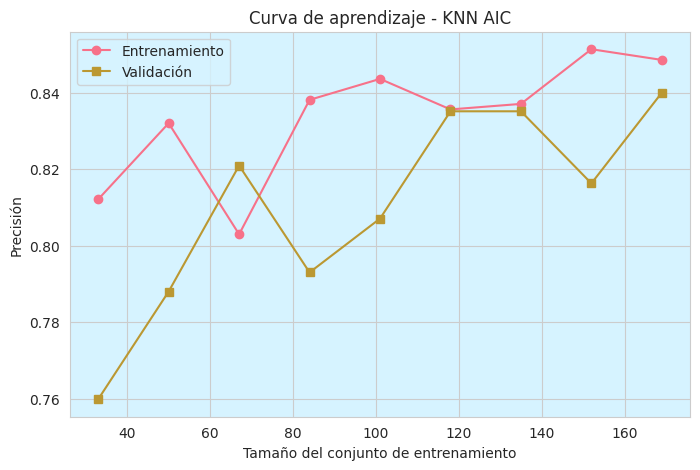

In [ ]:
Curva_aprendizaje(knn_AIC, X_train_AIC, "KNN AIC")

Este gráfico muestra cómo se comporta el modelo KNN cuando lo entrenamos con las variables seleccionadas por AIC. La línea roja representa la precisión en entrenamiento, y la amarilla en validación. Al inicio, el modelo acierta bastante en entrenamiento, pero esa precisión baja un poco conforme aumentamos el tamaño del conjunto, lo cual es normal porque se reduce el sobreajuste. En cambio, la precisión en validación empieza más baja pero mejora progresivamente, y ambas curvas se van acercando. Eso es buena señal: significa que el modelo está aprendiendo de forma estable y generaliza bien. En resumen, mientras más datos le damos, mejor se comporta, y a partir de cierto punto (más de 100 observaciones), ya se estabiliza y se vuelve confiable.

##### Curva de Aprendizaje de MLP - Boruta: 0.857

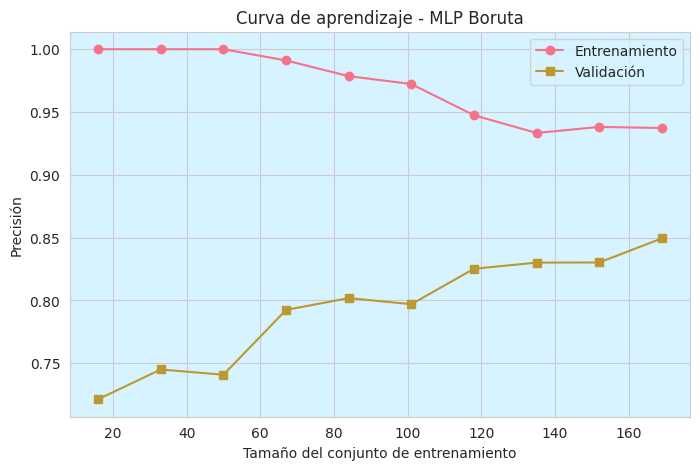

In [ ]:
Curva_aprendizaje(mlp_Boruta, X_train_Boruta, "MLP Boruta")

Este gráfico muestra cómo se comporta el modelo MLP cuando lo entrenamos con las variables seleccionadas por Boruta. La línea roja representa la precisión en entrenamiento, que empieza en 1.00 y se mantiene bastante alta, aunque baja un poco conforme aumentamos el tamaño del conjunto. Eso indica que el modelo aprende muy bien desde el inicio, pero también que puede estar sobreajustando si no se controla. Por otro lado, la línea amarilla muestra la precisión en validación, que empieza más baja (alrededor de 0.72) pero mejora de forma constante hasta estabilizarse cerca de 0.85. Esa subida progresiva es buena señal: significa que el modelo se va adaptando mejor a los datos reales conforme tiene más ejemplos. En conjunto, el gráfico sugiere que el MLP con Boruta tiene buen potencial, pero necesita suficiente cantidad de datos para generalizar bien y evitar que se quede solo en lo que memoriza.

##### Curva de Aprendizaje de LogReg - AIC: 0.849

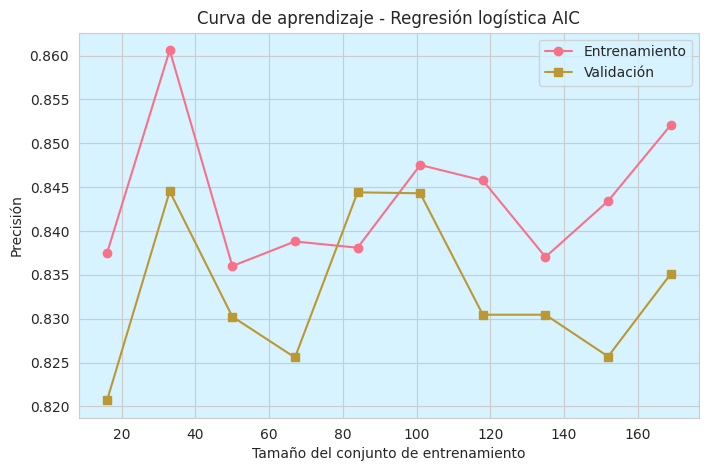

In [ ]:
Curva_aprendizaje(log_reg_AIC, X_train_AIC, "Regresión logística AIC")

El gráfico muestra cómo se comporta la regresión logística cuando se entrena con las variables seleccionadas por AIC. La línea roja representa la precisión en entrenamiento, que empieza alta y se mantiene bastante estable, mientras que la línea amarilla muestra la precisión en validación, que arranca más baja pero va mejorando conforme se incrementa el tamaño del conjunto de entrenamiento. Lo interesante es que ambas curvas se acercan progresivamente, lo cual indica que el modelo está generalizando bien y no está sobreajustando. En resumen, la regresión logística con AIC logra un buen equilibrio entre aprendizaje y validación, y se estabiliza con un rendimiento confiable cuando se entrena con más de 100 observaciones.

##### Curva de Aprendizaje de LogReg - Boruta: 0.843

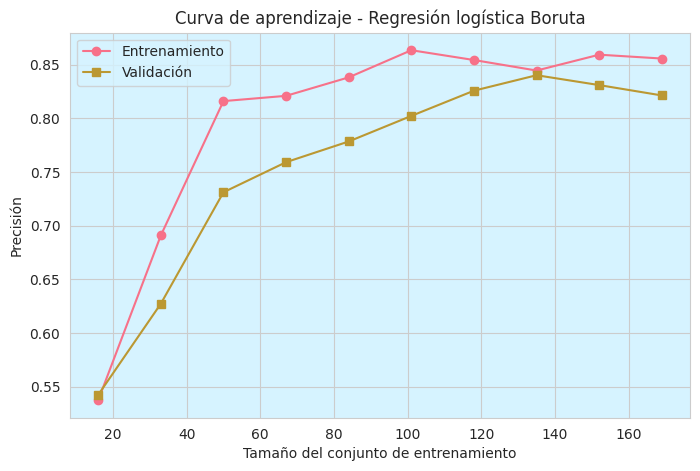

In [ ]:
Curva_aprendizaje(log_reg_Boruta, X_train_Boruta, "Regresión logística Boruta")

El gráfico muestra cómo se comporta la regresión logística cuando se entrena con las variables seleccionadas por Boruta. La línea roja representa la precisión en entrenamiento, que se mantiene alta y bastante estable, mientras que la línea amarilla muestra la precisión en validación, que empieza más baja pero va mejorando conforme se incrementa el tamaño del conjunto de entrenamiento. Lo importante es que ambas curvas se acercan sin cruzarse ni separarse demasiado, lo que indica que el modelo está aprendiendo de forma controlada y generaliza bien. En resumen, la regresión logística con Boruta logra un rendimiento sólido y estable, y no parece estar sobreajustando ni subajustando. Es una opción confiable, especialmente cuando se dispone de un conjunto de datos suficientemente amplio.

##### Curva de Aprendizaje de MLP - AIC: 0.843

In [ ]:
Curva_aprendizaje(mlp_AIC, X_train_AIC, "MLP AIC")

Este gráfico muestra cómo se comporta el modelo MLP cuando se entrena con las variables seleccionadas por AIC. La línea rosada representa la precisión en entrenamiento, que empieza muy alta pero va bajando conforme se incrementa el tamaño del conjunto de entrenamiento. Eso indica que el modelo al inicio memoriza bien, pero al tener más datos empieza a generalizar mejor y deja de sobreajustar. Por otro lado, la línea amarilla muestra la precisión en validación, que comienza más baja pero mejora de forma constante hasta estabilizarse cerca de 0.85. Esta convergencia entre ambas curvas es señal de que el modelo está aprendiendo de forma saludable. En resumen, el MLP con AIC necesita una buena cantidad de datos para alcanzar su mejor rendimiento, pero una vez que lo logra, generaliza bastante bien y se vuelve confiable.

### Interpretar el modelo

KNN con AIC logra el mejor equilibrio entre rendimiento, estabilidad y simplicidad. Es fácil de interpretar, rápido de ajustar, y generaliza bien. En un entorno clínico, donde la claridad y la precisión son clave, este modelo tiene todo para ser el elegido.

Interpretamos el mejor modelo (Boruta)

In [ ]:
# 1. Métricas generales
print("=== MÉTRICAS FINALES KNN AIC ===")
print(f"Accuracy : {accuracy_score(yc_te, y_pred_knn_AIC):.3f}")
print(f"Precision: {precision_score(yc_te, y_pred_knn_AIC):.3f}")
print(f"Recall   : {recall_score(yc_te, y_pred_knn_AIC):.3f}")
print(f"F1-Score : {f1_score(yc_te, y_pred_knn_AIC):.3f}")
print(f"AUC-ROC  : {roc_auc_score(yc_te, y_proba_knn_AIC):.3f}")  # aquí usamos las probabilidades

# 2. Reporte detallado por clase
print("\n=== REPORTE POR CLASE KNN AIC ===")
print(classification_report(yc_te, y_pred_knn_AIC, target_names=['Sano', 'Enfermo']))

=== MÉTRICAS FINALES KNN AIC ===
Accuracy : 0.846
Precision: 0.938
Recall   : 0.714
F1-Score : 0.811
AUC-ROC  : 0.922

=== REPORTE POR CLASE KNN AIC ===
              precision    recall  f1-score   support

        Sano       0.80      0.96      0.87        49
     Enfermo       0.94      0.71      0.81        42

    accuracy                           0.85        91
   macro avg       0.87      0.84      0.84        91
weighted avg       0.86      0.85      0.84        91



#### Feature importance

In [ ]:
# Calcular importancia de características con Permutation Importance
perm_importance = permutation_importance(
    knn_AIC, X_train_AIC, yc_tr, n_repeats=30, random_state=42, scoring='accuracy' )

# Crear DataFrame con resultados
feature_importance = pd.DataFrame({
    'Variable': X_train_AIC.columns,
    'Importancia_Media': perm_importance.importances_mean,
    'Importancia_Std': perm_importance.importances_std })

# Ordenar por importancia descendente
feature_importance = feature_importance.sort_values(by='Importancia_Media', ascending=False)

# Visualizar las 15 variables más importantes
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importancia_Media',
    y='Variable',
    data=feature_importance.head(15),
    palette='viridis' )


plt.title("Importancia de Características – Modelo KNN (AIC)", fontsize=14, fontweight='bold')
plt.xlabel("Importancia Media (Permutation Importance)")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# Mostrar tabla con las variables más importantes
print("\n📊 Variables ordenadas por importancia (KNN AIC):")
display(feature_importance.head(15))

#### INTERPRETACIÓN DE COEFICIENTES

In [ ]:
print("\n🔬 FASE 4.2: INTERPRETACIÓN DE VARIABLES")
print("En modelos no lineales como KNN o MLP no existen coeficientes.")
print("Usamos Permutation Importance para medir la relevancia de cada variable.")

# Calcular importancia de características
perm_importance = permutation_importance(
    knn_AIC, X_train_AIC, yc_tr, n_repeats=30, random_state=42, scoring='accuracy'
)

# Construir dataframe con resultados
coef_df = pd.DataFrame({
    'Variable': X_train_AIC.columns,
    'Importancia_Media': perm_importance.importances_mean,
    'Importancia_Std': perm_importance.importances_std,
    'Abs_Importancia': np.abs(perm_importance.importances_mean)
})

# Ordenar por magnitud
coef_top = coef_df.sort_values('Abs_Importancia', ascending=False).head(10)
print(coef_top)  # opcional

print("\nTOP 10 VARIABLES MÁS INFLUYENTES EN EL MODELO KNN AIC:")
for _, row in coef_top.iterrows():
    var = row['Variable']
    imp = row['Importancia_Media']
    direction = "aumenta precisión" if imp > 0 else "reduce precisión"
    print(f"  • {var:25s}:")
    print(f"      - Importancia media: {imp:.3f}")
    print(f"      - Interpretación: esta variable {direction} del modelo en validación")

# Gráfico de barras con las variables más influyentes
plt.figure(figsize=(10,6))
sns.barplot(x='Importancia_Media', y='Variable', data=coef_top, palette='viridis')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title("Top 10 Variables por Influencia – KNN AIC", fontsize=14, fontweight='bold')
plt.xlabel("Importancia (Permutation Importance)")
plt.ylabel("Variable")
plt.show()

In [ ]:
!jupyter nbconvert --to html GAD_Heart_Disease_Prediction.ipynb